In [7]:
import torch

In [8]:
# to form the table
import pandas as pd
import numpy as np

# To load and save files
import os
import glob
import pickle


import seaborn as sns
import scipy
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.io as sio
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
from matplotlib.pyplot import show 
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.widgets import TextBox
import matplotlib.cm as cm
import matplotlib.image as mpimg 
import matplotlib.colors

In [9]:

## set personal saving/ retrieving configuration

## Loading data
load_data=0
load_new_neurons=0 # set to 1 to load, else retrieved
# define where emg recording is retrieved from (matlab file)
location_mat_file='/Volumes/Extreme_SSD/Projectome_Estimation/filtered_objects/RCPoints_MR012_subset.mat'
# define simulation is retrieved from (csv file)
location_simulation_file='/Volumes/Extreme_SSD/Projectome_finder/data/senn_single_pulse'
## Set subject and lead position
subject='MR012'
lead='GO2'


## Plotting
save_plot=0 # set to 1 to automatically save all the plots
#define location where plots should be saved
# location_save_plots=f'Volumes/Extreme_SSD/Projectome_finder/plots/{subject}/' #somehow doesnt work here
location_save_plots=f'/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/plots/{subject}/'
os.makedirs(location_save_plots,exist_ok=True)
#Define where images used in the plot are saved
location_image="/Volumes/Extreme_SSD/Projectome_finder/Images_for_plot"



## if a new dataset should be loaded else dataset will be retrieved
#define location where data should be saved
location_data_dump=f'/Volumes/Extreme_SSD/Projectome_finder/CSV_and_pickle/{subject}/'
os.makedirs(location_data_dump,exist_ok=True)




## Save figure

In [10]:

def save_figure(folder_name, data_file,location_save_plots=location_save_plots ):
    """
    A function to get the number for the heatmap by by taking the  electric current at the point where afferent recruitment reaches 100%.
    
    Parameters
    ----------
    folder_name
        which folder should it be saved to? eg. recruitment/roots
    data_file
        name of plot
    location_save_plots
        location where plots should be save, set in the beginning
    """
    data_folder = location_save_plots
    save_folder = os.path.join(data_folder,folder_name)
    os.makedirs(save_folder,exist_ok=True)
    data_file_path = os.path.join(save_folder,data_file)
    plt.savefig(data_file_path, transparent = "False",  
    facecolor='w', 
    bbox_inches='tight'
            )
    print(f" figure saved: {data_file_path} ")

# Load data

## Muscles: Load new data and create a tensor

### Loading an RC from Matlab into Python
We load a previously saved RCpoints from Matlab into point for later manipulation as tensor.

**structure of a RCPoint**
* Lead -> implanted lead
* Position -> repositioning ID from during surgery
* Electrode -> 0-based electrode numbering
* Amp -> stimulation amp
* EMGs_filt -> filtered EMG responses
* NormConsts -> normalization constants that were used based on maximal responses
* muscle -> median of peak-to-peak of responses (real value if only one pulse at this amplitude)
* muscle_all -> all peak-to-peaks for the responses at same amplitude

In [11]:
#%matplotlib inline

Loading the file

In [12]:
if load_data:
    mat_contents = sio.loadmat(location_mat_file,squeeze_me=True)
    print(type(mat_contents['subsetRC']))
    subset_array=mat_contents['subsetRC']
    n_cells=len(subset_array)

    # Cells are trials
    n_trials=n_cells

    # We load 1 cell and go all the way to get the key names.
    i_cell = 0 
    cell_i=subset_array[i_cell]
    keys_cell_i = cell_i.dtype.names
    print("keys_cell_i",keys_cell_i)
    n_keys_cell_i=len(keys_cell_i)
    print("n_keys_cell_i",n_keys_cell_i)

In [13]:
if load_data:    
    # Let's declare the keys independently so that it becomes easier to go through them
    key_lead=keys_cell_i[0]
    key_position=keys_cell_i[1]
    key_electrode=keys_cell_i[2]
    key_amplitude=keys_cell_i[3]
    key_emg_time_series=keys_cell_i[4]
    key_normalization_constants_list=keys_cell_i[5]
    indices_median_peak2peak=np.arange(6,38,2)
    indices_median_peak2peak=indices_median_peak2peak.astype(int)
    keys_median_peak2peak_muscle=[keys_cell_i[index] for index in indices_median_peak2peak]
    indices_all_peak2peak=np.arange(7,39,2)
    indices_all_peak2peak=indices_all_peak2peak.astype(int)
    keys_all_peak2peak_muscle=[keys_cell_i[index] for index in indices_all_peak2peak]
    indices_movements_peak2peak=np.arange(38,46,1)
    indices_movements_peak2peak=indices_movements_peak2peak.astype(int)
    keys_movements_peak2peak_muscle=[keys_cell_i[index] for index in indices_movements_peak2peak]
    n_movements_peak2peak_muscle=len(keys_movements_peak2peak_muscle)

In [14]:
if load_data:
    # Now let's open up a EMG time serie struct array and take the keys
    emg_filt_time_series_cell_i=cell_i[key_emg_time_series].item()
    keys_emg_filt_time_serie_cell_i = emg_filt_time_series_cell_i.dtype.names
    print("keys_emg_filt_time_serie_cell_i",keys_emg_filt_time_serie_cell_i)
    n_keys_emg_filt_time_serie_cell_i=len(keys_emg_filt_time_serie_cell_i)
    print("n_keys_emg_filt_time_serie_cell_i",n_keys_emg_filt_time_serie_cell_i)

    # Now let's open up a normalization constants serie struct array and take the keys
    normalization_constants_list_cell_i=cell_i[key_normalization_constants_list].item()
    keys_normalization_constants_list_cell_i = normalization_constants_list_cell_i.dtype.names
    print("keys_normalization_constants_list_cell_i",keys_normalization_constants_list_cell_i)
    n_keys_normalization_constants_list_cell_i=len(keys_normalization_constants_list_cell_i)
    print("n_keys_emg_filt_time_serie_cell_i",n_keys_normalization_constants_list_cell_i)

The keys from the EMG filt time serie, the list of the normalization constants and the keys_median_peak2peak_muscle seem to be the list of muscles (16 muscles) and they are identical. The keys_all_peak2peak_muscle have an \_all appendend to each muscle name.

In [15]:
if load_data:
    # Getting a specific EMG filt time serie
    j_muscle_EMG_filt_time_serie_cell_i=0
    key_muscle_j_EMG_filt_time_serie_cell_i=keys_emg_filt_time_serie_cell_i[j_muscle_EMG_filt_time_serie_cell_i]
    print("key_muscle_j_EMG_filt_time_serie_cell_i",key_muscle_j_EMG_filt_time_serie_cell_i)
    muscle_j_EMG_filt_time_serie_cell_i=emg_filt_time_series_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i].item()

In [16]:
if load_data:
    lead_cell_i=cell_i[key_lead].item()
    position_cell_i=cell_i[key_position].item()
    electrode_cell_i=cell_i[key_electrode].item()
    amplitude_cell_i=cell_i[key_amplitude].item()
    key_muscle_j_EMG_filt_time_serie_cell_i=key_muscle_j_EMG_filt_time_serie_cell_i
    normalization_constant_muscle_j_cell_i=normalization_constants_list_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i].item()
    title_string=lead_cell_i+' - Position: '+str(position_cell_i)+' - Electrode: '+str(electrode_cell_i)+' - Amplitude: '+str(amplitude_cell_i)
    label_string="Muscle "+key_muscle_j_EMG_filt_time_serie_cell_i+' - normalized with:'+"{:10.2f}".format(normalization_constant_muscle_j_cell_i)
    fig = plt.figure(figsize=(7,7))
    plt.plot(muscle_j_EMG_filt_time_serie_cell_i,label=label_string)
    plt.legend()
    plt.xlabel("Timepoint")
    plt.ylabel("Filtered EMG")
    plt.title(title_string)
    plt.grid()
    plt.show

In [17]:
if load_data:
    # Getting the peak to peak saved values for all muscles
    median_peak2peak_muscles_cell_i=cell_i[keys_median_peak2peak_muscle]
    median_peak2peak_muscle_j_cell_i=median_peak2peak_muscles_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i].item()

    # Getting the all peak to peak for this particular muscle
    key_muscle_j_EMG_filt_time_serie_cell_i_all=key_muscle_j_EMG_filt_time_serie_cell_i+"_all"
    all_peak2peak_muscles_cell_i=cell_i[keys_all_peak2peak_muscle]
    all_peak2peak_muscle_j_cell_i=all_peak2peak_muscles_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i_all].item()

    # For the movements let us keep them everywhere since we have little info about them so far
    movements_peak2peak_muscle_cell_i=cell_i[keys_movements_peak2peak_muscle]
    for k_movement in range(n_movements_peak2peak_muscle):
        key_movement_k_peak2peak_cell_i=keys_movements_peak2peak_muscle[k_movement]
        movement_k_peak2peak_cell_i=movements_peak2peak_muscle_cell_i[key_movement_k_peak2peak_cell_i].item()
        print(key_movement_k_peak2peak_cell_i,movement_k_peak2peak_cell_i)

### Data frame construction

Now let us build a dataframe with all the data for later processing.

In [18]:
if load_data:
    verbose=1
    subject = 'MR012'
    n_rows_to_display = 5
    pd.set_option('display.max_rows', n_rows_to_display)
    print(f"n_keys_emg_filt_time_serie_cell_i: {n_keys_emg_filt_time_serie_cell_i}")

In [19]:
if load_data:
    list_elec_config_dfs = []
    if verbose:
        print("Loading data of subject:",subject)
    for i_cell in range(n_cells):
        if verbose:
            print("Loading cell: ",i_cell)
        cell_i=subset_array[i_cell]
        keys_cell_i = cell_i.dtype.names
        if verbose>2:
            print("keys_cell_i",keys_cell_i)
        n_keys_cell_i=len(keys_cell_i)
        if verbose>2:
            print("n_keys_cell_i",n_keys_cell_i)
        # Getting the info with the previously extracted keys
        lead_cell_i=cell_i[key_lead].item()
        position_cell_i=cell_i[key_position].item()
        electrode_cell_i=cell_i[key_electrode].item()
        amplitude_cell_i=cell_i[key_amplitude].item()
        # Lists
        median_peak2peak_muscles_cell_i=cell_i[keys_median_peak2peak_muscle]
        all_peak2peak_muscles_cell_i=cell_i[keys_all_peak2peak_muscle]
        movements_peak2peak_muscle_cell_i=cell_i[keys_movements_peak2peak_muscle]
        # Structured arrays with arrays inside
        emg_filt_time_series_cell_i=cell_i[key_emg_time_series].item()
        normalization_constants_list_cell_i=cell_i[key_normalization_constants_list].item()
        # Getting time series
        for j_muscle_EMG_filt_time_serie_cell_i in range(n_keys_emg_filt_time_serie_cell_i):
            key_muscle_j_EMG_filt_time_serie_cell_i=keys_emg_filt_time_serie_cell_i[j_muscle_EMG_filt_time_serie_cell_i]
            key_muscle_j_EMG_filt_time_serie_cell_i_all=key_muscle_j_EMG_filt_time_serie_cell_i+"_all"
            median_peak2peak_muscle_j_cell_i=median_peak2peak_muscles_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i].item()
            all_peak2peak_muscle_j_cell_i=all_peak2peak_muscles_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i_all].item()
            # if verbose: 
            #     print("Muscle",key_muscle_j_EMG_filt_time_serie_cell_i)
            muscle_j_EMG_filt_time_serie_cell_i=emg_filt_time_series_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i].item()
            n_time_points_trial=len(muscle_j_EMG_filt_time_serie_cell_i)
            if n_time_points_trial!=1000:
                print(key_muscle_j_EMG_filt_time_serie_cell_i,n_time_points_trial )
            
            normalization_constant_muscle_j_cell_i=normalization_constants_list_cell_i[key_muscle_j_EMG_filt_time_serie_cell_i].item()
            # Creating the dataframe
            df_trial_muscle_and_other_i_data = pd.DataFrame(data=[[muscle_j_EMG_filt_time_serie_cell_i]],columns=[key_emg_time_series])
            df_trial_muscle_and_other_i_data['Time_points'] = n_time_points_trial
            df_trial_muscle_and_other_i_data['Muscle'] = key_muscle_j_EMG_filt_time_serie_cell_i
            df_trial_muscle_and_other_i_data['Elec_config'] = electrode_cell_i
            df_trial_muscle_and_other_i_data['Subject'] = subject
            df_trial_muscle_and_other_i_data['Amplitudes'] = amplitude_cell_i
            df_trial_muscle_and_other_i_data['Lead'] = lead_cell_i
            df_trial_muscle_and_other_i_data['Position'] = position_cell_i
            df_trial_muscle_and_other_i_data['Normalization_Constant'] = normalization_constant_muscle_j_cell_i
            df_trial_muscle_and_other_i_data['Median_Peak2Peak'] = median_peak2peak_muscle_j_cell_i
            df_trial_muscle_and_other_i_data['All_Peak2Peak'] = [all_peak2peak_muscle_j_cell_i]
            # filling the movements
            for k_movement in range(n_movements_peak2peak_muscle):
                key_movement_k_peak2peak_cell_i=keys_movements_peak2peak_muscle[k_movement]
                movement_k_peak2peak_cell_i=movements_peak2peak_muscle_cell_i[key_movement_k_peak2peak_cell_i].item()
                df_trial_muscle_and_other_i_data[key_movement_k_peak2peak_cell_i] = movement_k_peak2peak_cell_i
                if verbose>1:
                    print(key_movement_k_peak2peak_cell_i,movement_k_peak2peak_cell_i)
            list_elec_config_dfs.append(df_trial_muscle_and_other_i_data)
    if len(list_elec_config_dfs)>0:
        df_subject = pd.concat(list_elec_config_dfs, ignore_index=True)
        df_subject.reset_index(inplace=True)  


In [20]:
if load_data:
    print(df_subject)

### Save the df

In [21]:
if load_data:
    mt_electrodes=pd.DataFrame(df_subject['Elec_config'].unique(), columns=["elec_name"])  #Elec01_, Elec02_, Elec03_, 
    mt_muscles=pd.DataFrame(df_subject['Muscle'].unique(), columns=["muscle_name"]) #LVlat, LST, ..
    unique_amplitudes=pd.DataFrame(df_subject['Amplitudes'].unique(), columns=["amplitude_name"])
    

    
    mt_electrodes.to_csv(location_data_dump+'mt_electrodes.csv')
    mt_muscles.to_csv(location_data_dump+'mt_muscles.csv')
    unique_amplitudes.to_csv(location_data_dump+'unique_amplitudes.csv')
    df_subject.to_csv(location_data_dump+'df_subject.csv')



### Create tensor

In [22]:
#device =  "cuda" if torch.cuda.is_available() else "cpu"

Max reps evt not used in the future, better to take the mean already, but also think on how to make it automatic

In [23]:

# def unique(list1):
#     x = np.array(list1)
#     print(np.unique(x))

# max_reps=unique(max(reps))


#### Create filtered data tensor

Manually adjustable if tensors should be created

In [24]:
create_tensor=load_data

In [25]:
#electrodes
#muscles
#amplitudes
#max_reps
#filtered EMG
if create_tensor:
    max_reps=39 # see notebook 6
    time_points=1000

    filtered_data_to_tensor=torch.ones(len(mt_electrodes['elec_name']),len(mt_muscles['muscle_name']),len(unique_amplitudes),max_reps,time_points)
    filtered_data_to_tensor.size()

In [26]:
## make it work with df
if create_tensor:
    for elec_i in range (len(mt_electrodes['elec_name'])) : #loop through all the elecs
        for muscle_i in range (len(mt_muscles['muscle_name'])): # loop through all the muscles
            amp_index=0
            data_amp_index=0
            print(f"elec: {elec_i} muscle:{muscle_i}")
            for amp_in_unique_amp in unique_amplitudes: # loop through all the amplitudes
                print("#####################################################")
                print(f"searching for data for amplitude {amp_in_unique_amp}")
                reps=0

                #compare length, in order to stop after max amplitude of a combiantion
                if data_amp_index < len(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )]["Amplitudes"]): 
                    #Check for which amplitudes there is data
                    print("passed checkpoint, now check if aplitudes match")
                    data_amp=round(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )].reset_index().iloc[data_amp_index]["Amplitudes"], 2)
                    print(f"comparing unique: {amp_in_unique_amp} with data amp: {data_amp}")
                    if data_amp==amp_in_unique_amp:                        
                        #Fill the single reps with data
                        print("found a suiting amplitude")
                        print("Now how many reps")
                        checking_reps=df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )&(round(df_subject["Amplitudes"],2)== data_amp )]["Time_points"].item()

                        if checking_reps==1000:
                            print("only one trial")
                            # Fill data
                            filtered_data_to_tensor[elec_i, muscle_i, amp_index,reps,:]=torch.tensor(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i])&(round(df_subject["Amplitudes"], 2)== amp_in_unique_amp)]["EMGs_filt"].item())
                            # Fill left over with nan values
                            reps+=1 
                            filtered_data_to_tensor[elec_i, muscle_i, amp_index,reps:,:]=torch.zeros((len(filtered_data_to_tensor[elec_i, muscle_i, amp_index,reps:,0]),time_points)).float()
                            filtered_data_to_tensor[filtered_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                        #Fill the multiple reps with data
                        else:
                            while reps<checking_reps:
                                print("going through the while loop")
                                print(" fill data")
                                filtered_data_to_tensor[elec_i, muscle_i, amp_index,reps,:]=torch.tensor(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i])&(round(df_subject["Amplitudes"], 2)== amp_in_unique_amp)]["EMGs_filt"].item()[reps])
                                reps+=1

                            # Fill left over reps with nan
                            else: 
                                print("finished the while loop")
                                if checking_reps<max_reps:
                                    filtered_data_to_tensor[elec_i, muscle_i, amp_index,reps:,:]=torch.zeros((len(filtered_data_to_tensor[elec_i, muscle_i, amp_index,reps:,0]),time_points)).float()
                                    filtered_data_to_tensor[filtered_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                        
                        #increase the amplitude index by one
                        data_amp_index+=1
                        
                    #Fill the amplitudes without data with 'nan'
                    else:
                        print(f"No match for {amp_in_unique_amp} fill with nan")
                        filtered_data_to_tensor[elec_i, muscle_i, amp_index,:,:]=torch.zeros((max_reps,time_points)).float()
                        filtered_data_to_tensor[filtered_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                    
                    #increase the amplitude index by one
                    amp_index+=1 

                else:
                    print(f"No more data for this combination  fill all with nan")
                    filtered_data_to_tensor[elec_i, muscle_i, amp_index,:,:]=torch.zeros((max_reps,time_points)).float()
                    filtered_data_to_tensor[filtered_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                
    
  

#### Create peak to peak values tensor

In [27]:
#electrodes
#muscles
#amplitudes
#max_reps
#peak to peak value
if create_tensor:
    max_reps=39 # see notebook 6
    peak_to_peak_value=1


    peak2peak_data_to_tensor=torch.ones(len(mt_electrodes['elec_name']),len(mt_muscles['muscle_name']),len(unique_amplitudes),max_reps,peak_to_peak_value)
    peak2peak_data_to_tensor.size()

In [28]:

## make it work with df
if create_tensor:
    for elec_i in range (len(mt_electrodes['elec_name'])) : #loop through all the elecs
        for muscle_i in range (len(mt_muscles['muscle_name'])): # loop through all the muscles
            amp_index=0
            data_amp_index=0
            print(f" Data search for muscle: {muscle_i} and elec: {elec_i}")
            for amp_in_unique_amp in unique_amplitudes: # loop through all the amplitudes
                print("#####################################################")
                print(f"starting data search, for amp: {amp_in_unique_amp} ")
                reps=0
                # make sure loop doesnt exceed lenght of data, to evade error
                if  data_amp_index< len(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )]["Amplitudes"]): 
                    print("passed checkpoint")
                    
                    #Check for which amplitudes there is data
                    data_amp=round(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )].reset_index().iloc[data_amp_index]["Amplitudes"], 2)
                    print(f"comparing unique: {amp_in_unique_amp} with data amp: {data_amp}")
                    if data_amp==amp_in_unique_amp:
                        print("found a suiting amplitude")
                        
                        # fill meadian peak to peak value for that amplitude
                        print(f"Only one Rep, thus reps must be zero :{reps} ")
                        peak2peak_data_to_tensor[elec_i, muscle_i, amp_index,reps,:]=torch.tensor(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i])&(round(df_subject["Amplitudes"], 2)== amp_in_unique_amp)]["Median_Peak2Peak"].item())
                        reps+=1
                        peak2peak_data_to_tensor[elec_i, muscle_i, amp_index,reps:,:]=torch.zeros((len(peak2peak_data_to_tensor[elec_i, muscle_i, amp_index,reps:,0]),peak_to_peak_value)).float()
                        peak2peak_data_to_tensor[peak2peak_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                    
                        
                            
                         
                    else:
                        print("there is no data thus tensor filled with nan")
                        peak2peak_data_to_tensor[elec_i, muscle_i, amp_index,:,:]=torch.zeros(( max_reps,peak_to_peak_value)).float()
                        peak2peak_data_to_tensor[peak2peak_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                        print(f"pritning tensor slice for elec: {elec_i}, muscle:{muscle_i} and amp: {amp_in_unique_amp}")
                    
                    
                # Fill left over data with nan
                else:
                    #Fill  amplitude the with  nan
                    print(f"no more data for elec: {elec_i}, muscle:{muscle_i}")
                    peak2peak_data_to_tensor[elec_i, muscle_i, amp_index,:,:]=torch.zeros((max_reps,peak_to_peak_value)).float()
                    peak2peak_data_to_tensor[peak2peak_data_to_tensor==0]= float('nan') #didn't find torch.nan function
                
                amp_index+=1

#### Create amplitude tensor 

In [29]:
if create_tensor:
    ### Create tensor with size torch.Size([16, 14, 32]) 
    # nMuslces x nElecs x nAmp_unique 
    amplitude_filtereddata_to_tensor=torch.ones(len(mt_electrodes['elec_name']),len(mt_muscles['muscle_name']),len(unique_amplitudes))
    amplitude_filtereddata_to_tensor.size()

In [30]:
##  working  with df :D
if create_tensor:
    ## Starting with elec 0, muslce 0, amp=0.5, filling the 10rows (repetition) for the spec. amp with the raw data/ resp nan value since there is no data for that amplitude
    for elec_i in range (len(mt_electrodes['elec_name'])) : #loop through all the elecs
        for muscle_i in range(len(mt_muscles['muscle_name'])): # loop through all the muscles
                
            ind=0 # set index to zero, will serve as index from amplitudes
            for pos_in_unique_amplitudes in range(len(unique_amplitudes)): #loop through all the amplitudes possible
                

                if len(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )]["Amplitudes"]) > ind: #Make sure not to exceed size of amplitude count
                    data_amp=round(df_subject[(df_subject["Elec_config"]==elec_i)&(df_subject["Muscle"]== mt_muscles['muscle_name'][muscle_i] )].reset_index().iloc[ind]["Amplitudes"], 2)


                    print(f"Amplitude of unique amp:{unique_amplitudes[pos_in_unique_amplitudes]}, {elec_i}, {mt_muscles['muscle_name'][muscle_i]},  data_amp:{data_amp}")

                    if data_amp > unique_amplitudes[pos_in_unique_amplitudes]:
                        print(f"No data for Amplitude: {unique_amplitudes[pos_in_unique_amplitudes]}, next amp with data: {data_amp} fill  nan for this amplitude")
                        amplitude_filtereddata_to_tensor[elec_i, muscle_i, pos_in_unique_amplitudes]=torch.zeros((1)).float()
                        amplitude_filtereddata_to_tensor[amplitude_filtereddata_to_tensor==0]= float('nan') #didn't find torch.nan function
                        
                    elif data_amp == unique_amplitudes[pos_in_unique_amplitudes]:
                        #save the amp with data
                        print("same amplitude")
                    
                        amplitude_filtereddata_to_tensor[elec_i, muscle_i, pos_in_unique_amplitudes]=torch.Tensor([data_amp])
                        ind+=1
                        print("#################################################################")

                
                else: #No more data for the remaining amplitudes in unique_amplitudes, thus fill with nan
                    print(f"In combination {elec_i}_{mt_muscles['muscle_name'][muscle_i]} no more data for {unique_amplitudes[pos_in_unique_amplitudes]}, nan value for this and following amplitudes")
                    # amplitude_data_to_tensor[elec_i, muscle_i, pos_in_unique_amplitudes:]=torch.zeros((len(unique_amplitudes)-pos_in_unique_amplitudes)).float()
                    amplitude_filtereddata_to_tensor[elec_i, muscle_i, pos_in_unique_amplitudes]=torch.zeros((1)).float()
                    amplitude_filtereddata_to_tensor[amplitude_filtereddata_to_tensor==0]= float('nan') #didn't find torch.nan function


### Save tensor as pickle file

In [31]:
### save files as pickle file  to projectome_finder#
if create_tensor:
 


    file = open(location_data_dump +'robin_data_tensor_dump.pkl', "wb")
    # file = open('/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/data/pickle_files/+'robin_data_tensor_dump.pkl', "wb")

    obj_1 = filtered_data_to_tensor #torch.Size([16, 16, 40, 39, 1000])
    obj_2 = amplitude_filtereddata_to_tensor #torch.Size([16, 16, 40])
    obj_3 = peak2peak_data_to_tensor #torch.Size([16, 16, 40, 39, 1])

    pickle.dump(obj_1, file)
    pickle.dump(obj_2, file)
    pickle.dump(obj_3, file)

    file.close()





## to retrieve ##
## file = open('/Users/nealarohner/Desktop/Projectome_Finder/code/Neala_Master_Thesis/data/pickle_files/robin_data_tensor_dump.pkl', 'rb')
# file = open(location_data_dump+'robin_data_tensor_dump.pkl', 'rb')
# filtered_data_to_tensor = pickle.load(file)
# amplitude_filtereddata_to_tensor  = pickle.load(file)
# peak2peak_data_to_tensor = pickle.load(file)

# file.close()

## Roots: Loading simulation and create a tensor
Neuron simulations from monopolar electromagnetic (=EM) simulations. (No AF with threshold as it is done for multipolar configurations). 
Same approach as Rowald*, Komi*, Demesmaeker* et al. 2022.
Due to the fact that the code was poorly mantained and not transmited, this part of the pipeline needed to be coded again.

Author: Sergio Daniel Hernandez Charpak

December 2022

In [32]:
def combine_concatenate_two_string_arrays(array_1,array_2,n_arrays=2,sep_string="_"):
	"""
    Given two arrays of strings, it computes all the different combinations of
    arrays[item_array_1, item_array_2] and then form the array of the concatenation
    of these two times [item_array_1"sep"item_array_2].
    @returns array of strings [item_i_array_1"sep"item_j_array_2]
    """
	comb_array = np.array(np.meshgrid(array_1, array_2)).T.reshape(-1,n_arrays)
	folders_to_iterate=[]
	for combination in comb_array:
		folder=""
		n_items_to_combine=len(combination)
		folder+=combination[0]
		for i in range(1,n_items_to_combine):
			folder+=(sep_string+combination[i])
		folders_to_iterate.append(folder)
	return folders_to_iterate

### Exploration
We explore one sim and one file to see how it is structred

In [33]:
if load_new_neurons:

    #get folder with simulations
    folder_raw_results=location_simulation_file
    #Each subfolder (for different lead placement)
    # contains the neuron simulation for each monopolar EM simulation.
    lead_pos=!ls $folder_raw_results
    print(lead_pos)
    electrodes=["E"+str(i).zfill(2) for i in range(16)]
    folder_raw_results_for_listing=os.path.join(folder_raw_results,'*')
    subfolder_list=glob.glob(folder_raw_results_for_listing)
    electrodes_from_listing=[folder_i[-3:] for folder_i in subfolder_list]
    n_monopolar_sims=len(electrodes_from_listing)

    # See how it is structured
    i_monopolar_sim=0
    monopolar_sim_i=electrodes_from_listing[i_monopolar_sim]
    monopolar_sim_sub_folder_i=subfolder_list[i_monopolar_sim]
    folder_files_monopolar_sim_sub_folder_i=os.path.join(monopolar_sim_sub_folder_i,'csv')
    folder_files_monopolar_sim_sub_folder_i_for_listing=os.path.join(folder_files_monopolar_sim_sub_folder_i,"*")
    files_monopolar_sim_sub_folder_i=glob.glob(folder_files_monopolar_sim_sub_folder_i_for_listing)
    n_total_fibers=len(files_monopolar_sim_sub_folder_i)
    i_fiber_sim=0
    file_fiber_i_sim=files_monopolar_sim_sub_folder_i[i_fiber_sim]
    df_fiber_i_sim=pd.read_csv(file_fiber_i_sim,sep=",")
    # All fibres per rootlet
    df_fiber_i_sim.head(50)
    df_fiber_i_sim.columns

We are mostly interested by the Tritration factor of each fiber. This is the key value to keep. For each tritration factor, fibers with a tritration factor smaller or equal to this value will count as active. For each factor we can then count the number of fibers active and the number of fibers inactive. These will be the values used to compute the recruitment percentages. 

In here each file contains the information for each rootlet (10 fibers per rootlet). 


We now have to :
* Get all this information in a dataframe. 
* Find the maximum overall tritration factor of the simulation (for each monopolar electrode)
* Find for each **Root** (not rootlet) the max tritration factor
* Do the counting of active fibers and inactive fibers
* Compute the recruitment

Found the method (implemented by Edoardo/Andreas):
```
Fiber_List = []
for root_idx, root_val in enumerate(Root_Name):
    for quad_idx,quad_val in enumerate(Quad_Name):
        for type_idx,type_val in enumerate(Type_Name):
            Fiber_List.append(root_val + '-' + quad_val + '_' + type_val)

for design in designs:
    for electrode in electrodes:

        filefolder = join(folderpath,design,electrode,'csv')
        titration_axes = [] # list holding titration factor from roots
        recruitment_percentage = [] # list holding recruitment percentage from roots
        for f_1 in Fiber_List:
            print f_1
            f = join(filefolder,'Titration_Sweeney - '+electrode+'_'+f_1+'.csv')
            titration_list = np.genfromtxt(join(filefolder,f), delimiter=',', skip_header=1)
            titration_list = titration_list[:,3] #remove later
            tdiv = np.linspace(np.min(titration_list), np.max(titration_list), datapoints) #number of data points
            rec=[]
            for t in tdiv:
                cn=0
                for tit in titration_list:
                    if tit<=t:
                        cn+=1
                rec.append(cn)
            rec=np.array(rec)
            percentage_rec = 100.*rec/n

            titration_axes.append(tdiv)
            recruitment_percentage.append(percentage_rec)

### Loading
Let us now load everything into one dataframe

In [34]:
if load_new_neurons:
    ## Define root names
    spinal_levels=["T12","L1","L2","L3","L4","L5","S1","S2","S3","S4"]
    quadrants=["DL","DR"]
    roots=combine_concatenate_two_string_arrays(spinal_levels,quadrants,n_arrays=2,sep_string="_")
    n_roots=len(roots)
    list_dfs_monopolar_sims=[]

    # Loop on the monopolar sims/electrodes
    for i_monopolar_sim in range(n_monopolar_sims):
        monopolar_sim_i=electrodes_from_listing[i_monopolar_sim]
        monopolar_sim_sub_folder_i=subfolder_list[i_monopolar_sim]
        folder_files_monopolar_sim_sub_folder_i=os.path.join(monopolar_sim_sub_folder_i,'csv')
        folder_files_monopolar_sim_sub_folder_i_for_listing=os.path.join(folder_files_monopolar_sim_sub_folder_i,"*")
        files_monopolar_sim_sub_folder_i=glob.glob(folder_files_monopolar_sim_sub_folder_i_for_listing)
        n_total_fibers=len(files_monopolar_sim_sub_folder_i)
        # Loop on the fibers from the file (fibers per rootlet)
        for i_fiber_sim in range(n_total_fibers):
            file_fiber_i_sim=files_monopolar_sim_sub_folder_i[i_fiber_sim]
            df_fiber_i_sim=pd.read_csv(file_fiber_i_sim,sep=",")
            # Find out which root it belongs to 
            # Gets a neuron name
            name_first_fiber_df_fiber_i_sim= df_fiber_i_sim['Neuron Name'][0]
            root_df_fiber_i=""
            for root_i in roots:
                if root_i in name_first_fiber_df_fiber_i_sim:
                    root_df_fiber_i=root_i
                    break
            df_fiber_i_sim['Root']=root_df_fiber_i
            spinal_level_df_fiber_i=""
            quadrant_df_fiber_i=""
            for spinal_level_i in spinal_levels:
                if spinal_level_i in root_df_fiber_i:
                    spinal_level_df_fiber_i=spinal_level_i
                    break
            df_fiber_i_sim['Spinal_Level']=spinal_level_df_fiber_i
            for quadrant_i in quadrants:
                if quadrant_i in root_df_fiber_i:
                    quadrant_df_fiber_i=quadrant_i
                    break
            df_fiber_i_sim['Quadrant']=quadrant_df_fiber_i
            df_fiber_i_sim['EM_Sim']=monopolar_sim_i
            list_dfs_monopolar_sims.append(df_fiber_i_sim)
    # Concat everything into one df
    df_neuron_sim=pd.concat(list_dfs_monopolar_sims,ignore_index=True)

    # Save the resulting dataframe
    file_name=f"Neuron_sim_{subject}_{lead}.csv"
    file_path=os.path.join(location_data_dump,file_name)
    os.makedirs(location_data_dump,exist_ok=True)
    df_neuron_sim.to_csv(file_path)

### Recruitment
Now we get the recruitmnet **per root** for each EM_Sim.

In [35]:
## Save recruitment values per combination  as dict and tensor ##
# dict because further processing with dict
# tensor if in future want to change all to one style
if load_new_neurons:
    # save a dict
    recruitment_simulation={}
    n_data_points=100 # Number of points which represents the "amplitude"
   
    ## create tensor
    #electrodes
    #roots
    #recruitment
    roots_recruitment_to_tensor=torch.ones(len(electrodes_from_listing),n_roots,100)
    print(roots_recruitment_to_tensor.size())

    ## Calculate recruitment ##
    # Loop through the monopolar EM simulations ( all the electrodes)
    for i_sim in range(n_monopolar_sims):
        sim_i=electrodes_from_listing[i_sim]
        # Get the results for this particular simulation (=particular electrode)
        df_neuron_sim_emSim_i=df_neuron_sim[df_neuron_sim['EM_Sim']==sim_i]
        # Get the min and max titration factors for this Neuron simulation
        min_trit_factor_sim_i=np.min(df_neuron_sim_emSim_i['Titration Factor'])
        max_trit_factor_sim_i=np.max(df_neuron_sim_emSim_i['Titration Factor'])
        
        # Form the array of titration factors
        trit_array_sim_i=np.linspace(min_trit_factor_sim_i,max_trit_factor_sim_i,n_data_points) # n_data_points=100
        # Loop through the simulated roots (all roots (L1 - T12))
        for i_root in range(n_roots):
            root_i=roots[i_root]
            # Get the results for this particular root for this particular simulation (5 rootlets for roots, 10 fibres per rootlet (=50 data points))
            df_neuron_sim_emSim_i_root_i=df_neuron_sim_emSim_i[df_neuron_sim_emSim_i['Root']==root_i] 
        
            ## Compute the recruitment
            # Only get the titration factor
            trit_factors_sim_i_root_i=df_neuron_sim_emSim_i_root_i['Titration Factor']
            # Prepare the results array
            recruitment_sim_i_root_i=np.zeros(np.shape(trit_array_sim_i)) 
            n_fibers_in_sim_i_root_i=len(trit_factors_sim_i_root_i) # 50, 5rootlets a 10 fibers

            # Loop through values of titration between the min and the max of the sim
            # activation can be 0 bc min value might be in a different root
            # min sim is equals no activation max sim equals max
            for i_trit in range(n_data_points): # Number of points which represents the "amplitude"
                trit_i=trit_array_sim_i[i_trit]
                # For a specific root, how many rootlets are activated at certain level (= titration factor) ?
                n_active_trit_i= (df_neuron_sim_emSim_i_root_i['Titration Factor'] <= trit_i).sum()
                # print(n_active_trit_i)
                recruitment_sim_i_root_i[i_trit]=n_active_trit_i
            recruitment_sim_i_root_i=recruitment_sim_i_root_i/n_fibers_in_sim_i_root_i

            # Prepare the output csv
            d_rec_emSim_i_root_i = {'Trit_Array': trit_array_sim_i, 'Recruitment': recruitment_sim_i_root_i}
            df_recruitment_emSim_i_root_i = pd.DataFrame(data=d_rec_emSim_i_root_i)
            df_recruitment_emSim_i_root_i['Root']=root_i
            df_recruitment_emSim_i_root_i['EM_Sim']=sim_i
            spinal_level_df_fiber_i=""
            quadrant_df_fiber_i=""
            for spinal_level_i in spinal_levels:
                if spinal_level_i in root_df_fiber_i:
                    spinal_level_df_fiber_i=spinal_level_i
                    break
            df_recruitment_emSim_i_root_i['Spinal_Level']=spinal_level_df_fiber_i
            for quadrant_i in quadrants:
                if quadrant_i in root_df_fiber_i:
                    quadrant_df_fiber_i=quadrant_i
                    break
            df_recruitment_emSim_i_root_i['Quadrant']=quadrant_df_fiber_i
            
            ## save in a tensor
            # electrode, root, reccruitment
            roots_recruitment_to_tensor[i_sim, i_root,:]=torch.tensor(df_recruitment_emSim_i_root_i['Recruitment'].values)

            ## Additional ways of saving ##
            # save create a class to save it as pickle file instead
            recruitment_simulation[f"_{electrodes_from_listing[i_sim]}_{roots[i_root]}"] = df_recruitment_emSim_i_root_i
        

    ## Dump files 
    #turn into df
    df_electrodes_for_roots= pd.DataFrame(electrodes_from_listing, columns =['electrode_name'])
    # save as csv
    df_electrodes_for_roots.to_csv(location_data_dump+'df_electrodes_for_roots.csv')
    # list version ; electrodes_from_listing
    
    #turn into df
    df_roots=pd.DataFrame(roots, columns =['root_name'])
    # save as csv                                       
    df_roots.to_csv(location_data_dump+'df_roots.csv')
    # list version ; roots

    # dump pickle file
    fh = open(location_data_dump+'recruitment_simulation_to_tensor'+'_'+subject+'.pkl', "wb")
    pickle.dump(roots_recruitment_to_tensor, fh)
    fh.close()
    fh = open(location_data_dump+'recruitment_simulation_as_dict'+'_'+subject+'.pkl', "wb")
    pickle.dump(recruitment_simulation, fh)
    fh.close()

## Retrieve pickle and csv data

### Muscles

In [36]:

if load_data==0:
    file = open(location_data_dump +'robin_data_tensor_dump.pkl', 'rb')
    filtered_data_to_tensor = pickle.load(file)
    amplitude_filtereddata_to_tensor  = pickle.load(file)
    peak2peak_data_to_tensor = pickle.load(file)

    file.close()



In [37]:

if load_data==0:
    # to retrieve ##
    mt_electrodes=pd.read_csv(location_data_dump+'mt_electrodes.csv')
    mt_muscles=pd.read_csv(location_data_dump+'mt_muscles.csv')
    unique_amplitudes=pd.read_csv(location_data_dump + 'unique_amplitudes.csv')

    electrodes=list(mt_electrodes["elec_name"])
    muscles=list(mt_muscles["muscle_name"])
    unique_amplitudes=list(unique_amplitudes["amplitudes"])

In [222]:
muscles_left=['LIL','LRF', 'LVL','LST', 'LTA','LMG','LSOL', 'LPS']
muscles_right=['RIL','RRF', 'RVL','RST', 'RTA','RMG','RSOL', 'RPS']
# for projectome
muscles_right_projectome= ['RIL','RRF_RVL',  'RST', 'RTA','RMG_RSOL']
muscles_left_projectome=['LIL','LRF_LVL',  'LST', 'LTA','LMG_LSOL']


### Roots

In [39]:
if load_new_neurons==0:



    with open(location_data_dump+'recruitment_simulation_to_tensor'+'_'+subject+'.pkl', 'rb') as handle:
        roots_recruitment_to_tensor = pickle.load(handle)
    with open(location_data_dump+'recruitment_simulation_as_dict'+'_'+subject+'.pkl', 'rb') as handle:
            recruitment_simulation = pickle.load(handle)

    df_electrodes_for_roots=pd.read_csv(location_data_dump+'df_electrodes_for_roots.csv')
    electrodes_from_listing=list(df_electrodes_for_roots["electrode_name"])
    df_roots=pd.read_csv(location_data_dump+'df_roots.csv')
    roots=list(df_roots["root_name"])
    # electrodes=list(electrodes_from_listing)

In [223]:
# separate left and right
roots_left=['T12_DL','L1_DL','L2_DL','L3_DL','L4_DL','L5_DL','S1_DL','S2_DL','S3_DL','S4_DL']
roots_right=['T12_DR','L1_DR','L2_DR','L3_DR','L4_DR','L5_DR','S1_DR','S2_DR','S3_DR','S4_DR']
# for projectome
roots_right_projectome =['L1_DR','L2_DR','L3_DR','L4_DR','L5_DR','S1_DR','S2_DR']
roots_left_projectome =['L1_DL','L2_DL','L3_DL','L4_DL','L5_DL','S1_DL','S2_DL']


## Filtered EMG

Plot the raw values,thus for every electrode-muscle combination you have a curve for every amplitude for that combination


In [41]:
def get_raw_emg_per_electrode(filtered_data_to_tensor=filtered_data_to_tensor,amplitude_filtereddata_to_tensor=amplitude_filtereddata_to_tensor, unique_amplitudes=unique_amplitudes, save_fig=0, mt_electrodes=mt_electrodes):
    """
    A function to create recruitment curves by electrode

    Parameters
    ----------
    filtered_data_to_tensor
        EMG data used for the recruitment curve, set by default
    amplitude_filtereddata_to_tensor
        Amplitudes used for the recruitment curve, set by default
    unique_amplitudes
        list with all the amplitudes
    save_fig
        int, if set to 1 save figure
    mt_electrodes
        pandas df, all ellectrodes used in data
    mt_muscles
        pandas df, all muscles used in data


    """

    for elec_i in range (0, len(mt_electrodes[0:1])):
        fig, ax = plt.subplots(figsize=(10,7))
        for muscle_i in range (len(mt_muscles[0:1])):
            for amplitude_i in range (0, len(amplitude_filtereddata_to_tensor[elec_i, muscle_i, :])):
                colors = cm.rainbow(np.linspace(0, 1, len(amplitude_filtereddata_to_tensor[elec_i, muscle_i, :])))
                # if no values for that amplitude break for loop
                if np.isnan(np.array(amplitude_filtereddata_to_tensor[elec_i, muscle_i, amplitude_i])):
                    continue
                # Define variables for plotting
                x = np.arange(0, len(filtered_data_to_tensor[elec_i, muscle_i, amplitude_i, 0, :]))
                y = filtered_data_to_tensor[elec_i, muscle_i, amplitude_i, 0, :]
    
                # Plot the data points
                plt.plot(x,  y, '-', c=colors[amplitude_i], label= unique_amplitudes[amplitude_i]) 
                
            plt.legend(title="Amplitude of current [mA]")
            # Set label and scale
            ax.set_xlabel("Timepoints [in 100 ms]") # freq. rate = 10kHz, 1000 time points
            # ax.set_xticks(ticks=np.linspace(start=0.2, stop=np.max(unique_amplitudes)+0.1, endpoint=True, num=25))
            ax.set_ylabel(f"filtered EMG [mV]")
            # ax.set_xticks(ticks=np.linspace(0, 100))

            # Plotting settings
            # ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            ax.set_title(f"Filtered EMG for elec: {elec_i} and muscle: {mt_muscles['muscle_name'][muscle_i]} ")
            
        ## save plots ##
        if save_fig:
            folder_name="Raw_EMG"
            data_file="elec"+"_"+str(elec_i)+"_"+"raw_emg"+'.png'
            save_figure(folder_name, data_file)

            plt.show()
    
       


In [42]:
def get_raw_emg_per_electrode(filtered_data_to_tensor=filtered_data_to_tensor,amplitude_filtereddata_to_tensor=amplitude_filtereddata_to_tensor, unique_amplitudes=unique_amplitudes, save_fig=0, mt_electrodes=mt_electrodes):
    """
    A function to create recruitment curves by electrode

    Parameters
    ----------
    filtered_data_to_tensor
        EMG data used for the recruitment curve, set by default
    amplitude_filtereddata_to_tensor
        Amplitudes used for the recruitment curve, set by default
    unique_amplitudes
        np.array with all the amplitudes
    save_fig
        int, if set to 1 save figure
    mt_electrodes
        pandas df, all ellectrodes used in data
    mt_muscles
        pandas df, all muscles used in data


    """

    for elec_i in range (0, len(mt_electrodes[0:1])):
        fig, ax = plt.subplots(figsize=(10,7))
        for muscle_i in range (len(mt_muscles[0:1])):
            for amplitude_i in range (0, len(amplitude_filtereddata_to_tensor[elec_i, muscle_i, :])):
                colors = cm.rainbow(np.linspace(0, 1, len(amplitude_filtereddata_to_tensor[elec_i, muscle_i, :])))
                # if no values for that amplitude break for loop
                if np.isnan(np.array(amplitude_filtereddata_to_tensor[elec_i, muscle_i, amplitude_i])):
                    continue
                # Define variables for plotting
                x = np.arange(0, len(filtered_data_to_tensor[elec_i, muscle_i, amplitude_i, 0, :]))
                y = filtered_data_to_tensor[elec_i, muscle_i, amplitude_i, 0, :]
    
                # Plot the data points
                plt.plot(x,  y, '-', c=colors[amplitude_i], label= unique_amplitudes[amplitude_i]) 
                
            plt.legend(title="Amplitude of current [mA]")
            # Set label and scale
            ax.set_xlabel("Timepoints [in 100 ms]") # freq. rate = 10kHz, 1000 time points
            # ax.set_xticks(ticks=np.linspace(start=0.2, stop=np.max(unique_amplitudes)+0.1, endpoint=True, num=25))
            ax.set_ylabel(f"filtered EMG [mV]")
            # ax.set_xticks(ticks=np.linspace(0, 100))

            # Plotting settings
            # ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            ax.set_title(f"Filtered EMG for elec: {elec_i} and muscle: {mt_muscles['muscle_name'][muscle_i]} ")
            
        ## save plots ##
        if save_fig:
            folder_name="Raw_EMG"
            data_file="elec"+"_"+str(elec_i)+"_"+"raw_emg"+'.png'
            save_figure(folder_name, data_file)

            plt.show()
    
       


In [43]:
if save_plot:
    get_raw_emg_per_electrode(save_fig=save_plot)


## Recruitment curves

### Plot EMG Processing (recruitment curve)
For the rectuitment curve per electrode, you have one value ( the peak to peak value) per amplitude for the different muscles.

#### Per electrode

In [44]:
def get_recruitment_curve_per_electrode(peak2peak_data_to_tensor=peak2peak_data_to_tensor,amplitude_filtereddata_to_tensor=amplitude_filtereddata_to_tensor, unique_amplitudes=unique_amplitudes, save_fig=0, mt_electrodes=mt_electrodes):
    """
    A function to create recruitment curves by electrode

    Parameters
    ----------
    peak2peak_data_to_tensor
        Peak to peak values of EMG data, used for the recruitment curve, set by default
    amplitude_filtereddata_to_tensor
        Amplitudes used for the recruitment curve, set by default
    unique_amplitudes
        np.array with all the amplitudes
    save_fig
        int, if set to 1 save figure
    mt_electrodes
        pandas df, all ellectrodes used in data
    mt_muscles
        pandas df, all muscles used in data


    """

    colors = cm.rainbow(np.linspace(0, 1, len(mt_muscles)))
    label=mt_muscles["muscle_name"]

    for elec_i in range (0, len(mt_electrodes)):
        fig, ax = plt.subplots(figsize=(10,7))
        for muscle_i in range (len(mt_muscles)):

            # Define variables for plotting
            x = amplitude_filtereddata_to_tensor[elec_i,muscle_i,:]
            y = peak2peak_data_to_tensor[elec_i, muscle_i, :, 0, 0]
        
            # Remove nan values
            x_without_nan=np.array(x)
            x_without_nan=x_without_nan[~np.isnan(x_without_nan)]
            y_without_nan=np.array(y)
            y_without_nan=y_without_nan[~np.isnan(y_without_nan)]

            # Plot the data points
            plt.plot(x_without_nan,  y_without_nan, 'o-', c=colors[muscle_i], label= mt_muscles['muscle_name'][muscle_i]) 
            
            # Add text descripiton to the points for visibility
            for index in range (len(x_without_nan)):
                ax.text(x_without_nan[index], y_without_nan[index], label[muscle_i], size=10) 
            
            # Set label and scale
            ax.set_xlabel("Amplitude [mA]")
            ax.set_xticks(ticks=np.linspace(start=0.2, stop=np.max(unique_amplitudes)+0.1, endpoint=True, num=25))
            ax.set_ylabel(f"Peak to peak value [mV]")
            ax.set_yticks(ticks=np.linspace(0, np.nanmax(peak2peak_data_to_tensor [:, :,:, 0, 0]), 11))

        # Plotting settings
        ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title="muscles")
        ax.set_title(f"Recruitment curve for elec: {elec_i}")

        ## save plots ##
        if save_fig:
            data_file = "elec"+"_"+str(elec_i)+"_"+"recruitment_curve"+'.png'
            folder_name="recruitment_curve/muscles/recruitment_per_elec"
            save_figure(folder_name, data_file)

        plt.show()


In [45]:
if save_plot:
    get_recruitment_curve_per_electrode(save_fig=save_plot)

#### Per muscle 

In [46]:

def get_recruitment_curve_per_muscles(peak2peak_data_to_tensor=peak2peak_data_to_tensor,amplitude_filtereddata_to_tensor=amplitude_filtereddata_to_tensor,unique_amplitudes=unique_amplitudes,  save_fig=0, mt_electrodes=mt_electrodes):
    """
    A function to create recruitment curves by muscle. 

    Parameters
    ----------
    peak2peak_data_to_tensor
        EMG data used for the recruitment curve, set by default
    amplitude_filtereddata_to_tensor
        Amplitudes used for the recruitment curve, set by default
    unique_amplitudes
        np.array with all the amplitudes
    save_fig
        int, if set to 1 save figure
    mt_electrodes
        pandas df, all ellectrodes used in data
    mt_muscles
        pandas df, all muscles used in data


    """
    colors = cm.rainbow(np.linspace(0, 1, len(mt_electrodes)))
    label=mt_electrodes["elec_name"]

    for muscle_i in range (len(mt_muscles)):
        fig, ax = plt.subplots(figsize=(10,7))
        for elec_i in range (0, len(mt_electrodes)):
        
            # Define variables for plotting
            x = amplitude_filtereddata_to_tensor[elec_i,muscle_i,:]
            y = peak2peak_data_to_tensor[elec_i, muscle_i, :, 0, 0]
        
            # Remove nan values for the text index
            x_without_nan=np.array(x)
            x_without_nan=x_without_nan[~np.isnan(x_without_nan)]
            y_without_nan=np.array(y)
            y_without_nan=y_without_nan[~np.isnan(y_without_nan)]

            # Plot the data points
            plt.plot(x_without_nan, y_without_nan, 'o-', c=colors[elec_i],  label=mt_electrodes['elec_name'][elec_i]) 
                
            # Add text descripiton to the points for visibility
            for index in range (len(x_without_nan)):
                ax.text(x_without_nan[index], y_without_nan[index], label[elec_i], size=10) 
            
            # Set label and scale
            ax.set_xlabel("Amplitude [mA]")
            ax.set_xticks(ticks=np.linspace(start=0.2, stop=np.max(unique_amplitudes)+0.1, endpoint=True, num=25))
            ax.set_ylabel(f"Peak to peak value [mV]")
            ax.set_yticks(ticks=np.linspace(0, np.nanmax(peak2peak_data_to_tensor [:, :,:, 0, 0]), 11))

        # Plotting settings
        ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title= "electrodes")
        ax.set_title(f"Recruitment curve for muscle {mt_muscles['muscle_name'][muscle_i]}")

        ## save plots ##
        if save_fig:
            data_file = mt_muscles['muscle_name'][muscle_i]+"_"+"recruitment_curve"+'.png'
            folder_name="recruitment_curve/muscles/recruitment_per_msc"
            save_figure(folder_name, data_file)


    plt.show()

In [47]:
if save_plot:
    get_recruitment_curve_per_muscles(save_fig=save_plot)


### Plot the simulations (recruitment curve)

In [48]:

def get_recruitment_curve_per_electrode(save_fig=save_plot,recruitment_simulation=recruitment_simulation, electrodes_from_listing=electrodes_from_listing, roots_left=roots_left, roots_right=roots_right):
    """
    A function to create recruitment curves by electrode

    Parameters
    ----------
    
    save_fig
        int, set to 1 to save figure
    recruitment_simulation
        dict with recruitment per electrode root combination,set by default
    electrodes_from_listing
        list, all ellectrodes used in data, set by default
    roots_left, roots_right
        list, all roots used in data, separated left and right, set by default


    """

    legend_title= "spinal roots"
    xLabel="Electric current [a.u]"
    yLabel="Afferent recruitment [%]"

    x=np.arange(0, 100)
    # Left activation
    for electrode in range (len(electrodes_from_listing)):
        plt.figure(figsize=(10, 10))
        plt.title(f"Left root activation for {electrodes_from_listing[electrode]} ")
        for root in roots_left:
            
            plt.plot(x,recruitment_simulation[f"_{electrodes_from_listing[electrode]}_{root}"]["Recruitment"], label=root)
            plt.legend(title=legend_title)
            plt.xlabel(xLabel)
            plt.ylabel(yLabel)

            if save_fig:
                print("figure is saved")
                data_file = electrodes_from_listing[electrode]+"_"+"recruitment_curve"+'.png'
                save_figure(folder_name="Recruitment_curve/roots", data_file=data_file)
            
        plt.show()

    # Right activation
    for electrode in range (len(electrodes_from_listing)):
        plt.figure(figsize=(10, 10))
        plt.title(f"Right root activation for {electrodes_from_listing[electrode]} ")
        for root in roots_right:
            
            plt.plot(x,recruitment_simulation[f"_{electrodes_from_listing[electrode]}_{root}"]["Recruitment"], label=root)
            plt.legend(title=legend_title)
            plt.xlabel(xLabel)
            plt.ylabel(yLabel)
            if save_fig:
                data_file = electrodes_from_listing[electrode]+"_"+"recruitment_curve"+'.png'
                save_figure(folder_name="Recruitment_curve/roots", data_file=data_file)
        plt.show()

In [49]:
if save_plot:
    get_recruitment_curve_per_electrode()

## Muscle/ Root recruitment processing

For now we have thought of two possibibilites how to process the recruitment curves and compare the actvation.

**A: Heatmap**

*Muscles:*\
Since there is an inconsistent sweep of amplitudes between the electrodes (some elctrodes are not stimulating as high as others) it's hard to compare the activation of the muscle between the electrodes and define the electrode(s) that predominantly activate a certain muscle.
Thus here we have different approaches to solve this problem:

Normalisation methods:
- Normalise by amplitude:
    - for peak to peak values: max output(max activation) / input(amp) at max activation
    - for integral (hasn't been done yet): output int /input (amp) bim max 
- Normalise by max value
- Selectivity index (described in paper)(not done yet) (not recommended)

*Roots:*\
The difficulty here is to get from a curve to a number to feed into the heatmap.
These are the different techniques/possibilites
(Choose the applying one in section: heatmap indiviudal roots -> plot the heatmap, function: get_heat_map_individual_root_recruitment)

Methods:
- get_number_for_heat_map_100_electric_current_normalise_by_max_root_response
- get_number_for_heat_map_100_electric_current 
- 1-[divide(root_elec_i_electric_current_at _100%,   overall_max_electric current_at_100%_root)] (to be coded)

For now the computation of the number to make a heatmap electrodes/roots 
we do one approach by taking the  electric current at the point where afferent recruitment reaches 100%.

**B: Fit recruitment to sigmoids**



### A: Heat map

#### Normalisation muscles


##### normalise_max_P2P_div_amp

For every muscle electrode combination the max muscle response is divided by the ampliude at that point. 
However with this method we don't take into account the impedance. There's a big variability between the different electrodes (eg  impedance given by tissue btw elec and return.  eg air bubble etc )
After having done the normalisation by amplitude, there is a problem with the low values for the interpolation: values between 0 and 1 will be rounded to zero. Thus we have to multiply it by 100 before interpolating
and change the plotting scale (vmin, and vmax) to 0 to 100, thus we should get to the same results and in the heatmap without interpolation where data_1 was used, and vmin=0 and vmax=1.


In [50]:
def set_normalisation_max_p2p_div_amp(mt_muscles=mt_muscles,mt_electrodes=mt_electrodes):
    """"
    Function to get a number for the heat map

    Parameters
    ----------
    mt_muscles
        df of all the muscles in the gait, set by default
    mt_electrodes
        df of all the electrodes used, set by default

    Output
    ----------
    data_normalised
        numpy array of values "normalised"
    """

    data_normalised=np.zeros((len(mt_muscles["muscle_name"]),len(mt_electrodes["elec_name"])))
    for muscle_i in range(0, len(mt_muscles)):
        for elec_i in range (0, len(mt_electrodes)):
            ## Find max value for one combination
            max_value=np.nanmax(peak2peak_data_to_tensor[elec_i, muscle_i, :, 0, 0])
            ## Divide max value by amplitude at max value to normalise (not just between muscles but also between elecs)
            max_value_amplitude=amplitude_filtereddata_to_tensor[elec_i,muscle_i,np.where(max_value==peak2peak_data_to_tensor[elec_i, muscle_i, :, 0, 0])[0][0]]
        
            max_value_normalised=np.divide(max_value,max_value_amplitude)
            data_normalised[muscle_i][elec_i]=max_value_normalised
    
    ## turn into a df
    data_normalised_df= pd.DataFrame(data_normalised, columns=mt_electrodes["elec_name"], index=mt_muscles["muscle_name"])

    print("normalisation method is: normalise_max_P2P_div_amp")
    return data_normalised_df


##### normalise_by_max_response



Idea of Robin : across all elecs,  take max response in the muscle (peak to peak ?, at any amp?)
and normalise by that. Here we take into account the impendance difference between the different electrodes.

In [51]:
# as df
def set_normalisation_by_max_response(mt_muscles=mt_muscles,mt_electrodes=mt_electrodes):
    """"
    Function to get a number for the heat map

    Parameters
    ----------
    mt_muscles
        df of all the muscles in the gait, set by default
    mt_electrodes
        df of all the electrodes used, set by default

    Output
    ----------
    data_normalised_df
        numpy array of values "normalised"
    """

    data_normalised=np.zeros((len(mt_muscles["muscle_name"]),len(mt_electrodes["elec_name"])))
    for muscle_i in range(0, len(mt_muscles)):
        for elec_i in range (0, len(mt_electrodes)):
            ## Find max response in the muscle
            max_value_for_muscle=np.nanmax(peak2peak_data_to_tensor[:, muscle_i, :, 0, 0])
            max_value_normalised=np.divide(np.nanmax(peak2peak_data_to_tensor[elec_i, muscle_i, :, 0, 0]), max_value_for_muscle)
        
            data_normalised[muscle_i][elec_i]= max_value_normalised

    ## turn into a df
    data_normalised_df= pd.DataFrame(data_normalised, columns=mt_electrodes["elec_name"], index=mt_muscles["muscle_name"])

    print("normalisation method is: normalise_max_response to df")
    print(" Data is in a df structure")
    return data_normalised_df

#### Normalisation Roots / Get nr for the heatmap

In [52]:
def get_number_for_heat_map_100_electric_current_normalise_by_max_root_response(electrodes_from_listing=electrodes_from_listing, roots=roots, recruitment_simulation=recruitment_simulation):

    """
    A function to get the number for the heatmap by by taking the  electric current 
    at the point where afferent recruitment reaches 100%.
    substracting this electric current from 100 
    and dividing it by the max muscle response for a muscle

    Parameters
    ----------
    electrodes_from_listing
        list, names of electrodes
    roots
        list, names of root
    recruitment_simulation
        dict with recruitment per electrode root combination,set by default
  
    Output
    ----------
    data_normalised_df
        df of values "normalised"
    """
    electric_current=np.zeros((len(roots),len(electrodes_from_listing)))
    for root_i in range(len(roots)):
        for elec_i in range (len(electrodes_from_listing)):
            # extract first index where recruitment =1.0
            # substract it from 100, since lower values in elec current show higher activation -> turn it
            electric_current[root_i ][elec_i]= 100-recruitment_simulation[f"_{electrodes_from_listing[elec_i]}_{roots[root_i]}"]["Recruitment"][np.where(1==recruitment_simulation[f"_{electrodes_from_listing[elec_i]}_{roots[root_i]}"]["Recruitment"])[0]].index[0]
            
    ## turn into a df
    # electric_current_df= pd.DataFrame(electric_current, columns=df_electrodes_for_roots["electrode_name"], index=df_roots["root_name"])
    electric_current_df= pd.DataFrame(electric_current, columns=df_electrodes_for_roots["electrode_name"], index=df_roots["root_name"])
    ##per root normalise it by max root response
    for root_i in roots:
        max_value_for_root=np.nanmax(electric_current_df.loc[root_i])
        electric_current_df.loc[root_i]=np.divide(electric_current_df.loc[root_i], max_value_for_root)

    print("normalisation method is: (100-electric_current)_normalise_by_max_root_response")
    return electric_current_df



In [53]:
def get_number_for_heat_map_100_electric_current(electrodes_from_listing=electrodes_from_listing, roots=roots, recruitment_simulation= roots_recruitment_to_tensor):

    """
    A function to get the number for the heatmap by by taking the  electric current 
    at the point where afferent recruitment reaches 100%.
    substracting this electric current from 100 
    and dividing it by the max muscle response for a muscle

    Parameters
    ----------
    electrodes_from_listing
        list, names of electrodes
    roots
        list, names of root
    recruitment_simulation
        dict with recruitment per electrode root combination,set by default
  
    Output
    ----------
    data_normalised_df
        df of values "normalised"
    """
    electric_current=np.zeros((len(roots),len(electrodes_from_listing)))
    for root_i in range(0, len(roots)):
        for elec_i in range (0, len(electrodes_from_listing)):
            # extract first index where recruitment =1.0
            # substract it from 100, since lower values in elec current show higher activation -> turn it
            electric_current[root_i ][elec_i]= 100-recruitment_simulation[f"_{electrodes_from_listing[elec_i]}_{roots[root_i]}"]["Recruitment"][np.where(1==recruitment_simulation[f"_{electrodes_from_listing[elec_i]}_{roots[root_i]}"]["Recruitment"])[0]].index[0]
            
    ## turn into a df
    electric_current_df= pd.DataFrame(electric_current, columns=df_electrodes_for_roots["electrode_name"], index=df_roots["root_name"])

    print("normalisation method is: 100-electric_current")
    return electric_current_df




#### Heatmap all muscles resp all roots

In [54]:

def get_heatmap_all_muscles_overview(save_fig=save_plot, mt_muscles=mt_muscles,mt_electrodes=mt_electrodes):
    """
    A function to create a heatmap.

    Parameters
    ----------

    save_fig
        int, if set to 1 save figure
    mt_muscles
        df of all the muscles in the gait, set by default
    mt_electrodes
        df of all the electrodes used, set by default
    """
            
    fig, ax = plt.subplots(figsize=(15,10))# creating subplot

    ## Define which normalisation method is used
    # data=set_normalisation_max_p2p_div_amp(mt_muscles=mt_muscles,mt_electrodes=mt_electrodes)
    # data_structure="normalise_max_P2P_div_amp"
    data=set_normalisation_by_max_response(mt_muscles=mt_muscles,mt_electrodes=mt_electrodes)
    data_structure="normalise_by_max_response"
    
    ## Define heatmap
    sns.heatmap(data=data, cmap="Reds", cbar=True,
    annot=True,  yticklabels=mt_muscles["muscle_name"],
    xticklabels=mt_electrodes["elec_name"],
    cbar_kws={'label': f"Muscle activation ['V/A']"},
    fmt='.2g' )
 
    ## Define ticks
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

    ## Define labels
    ax.set_title('Heat map for muscle activation per electrode', size=18, fontstyle='italic', pad=20)
    ax.set_ylabel('Muscles',  size=12, fontstyle='italic', labelpad=10, color="grey", fontweight="bold") 
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel('Electrodes', size=12, fontstyle='italic', labelpad=10, color="grey", fontweight="bold")

    
    ## Define Textbox
    print(f"Heat map is being created with Normalisation method: {data_structure}")
    axbox = fig.add_axes([0, 1.0, 0.2, 0.05]) #[left, bottom, width, height]
    text_box = TextBox(axbox,label=None, textalignment="center")
    text_box.set_val(data_structure)  # Trigger `submit` with the initial string.

    ## Save plots   
    if save_fig:
        folder_name= "heatmap/muscles"
        data_file = "Heat_map_all_muscles_"+ data_structure+'.png'
        save_figure(folder_name, data_file)

    plt.show()

    

In [55]:

def get_heatmap_all_roots_overview(save_fig=save_plot, roots=roots, electrodes_from_listing=electrodes_from_listing):
    """
    A function to create a heatmap.

    Parameters
    ----------

    save_fig
        int, if set to 1 save figure
    roots
        list of all the muscles in the gait, set by default
    electrodes_from_listing
        list of all the electrodes used, set by default
    """
            
    fig, ax = plt.subplots(figsize=(15,10))# creating subplot

    ## Define which normalisation method is used
    data=get_number_for_heat_map_100_electric_current_normalise_by_max_root_response()
    data_structure="100-electric_current_div_max_root_response"
    # data=get_number_for_heat_map_100_electric_current()
    # data_structure="100-electric_current"
    
    ## Define heatmap
    sns.heatmap(data=data, cmap="Reds", cbar=True,
    annot=True,  yticklabels=roots,
    xticklabels=electrodes_from_listing,
    cbar_kws={'label': f"Root activation [a.u]"},
    fmt='.2g' )
 
    ## Define ticks
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

    ## Define labels
    ax.set_title('Heat map for root activation per electrode', size=18, fontstyle='italic', pad=20)
    ax.set_ylabel('Roots',  size=12, fontstyle='italic', labelpad=10, color="grey", fontweight="bold") 
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel('Electrodes', size=12, fontstyle='italic', labelpad=10, color="grey", fontweight="bold")

    
    ## Define Textbox
    print(f"Heat map is being created with Normalisation method: {data_structure}")
    axbox = fig.add_axes([0, 1.0, 0.2, 0.05]) #[left, bottom, width, height]
    text_box = TextBox(axbox,label=None, textalignment="center")
    text_box.set_val(data_structure)  # Trigger `submit` with the initial string.

    ## Save plots   
    if save_fig:
        folder_name= "heatmap/muscles"
        data_file = "Heat_map_all_muscles_"+ data_structure+'_'+subject+'.png'
        save_figure(folder_name, data_file)

    plt.show()


In [56]:
if save_plot:
    get_heatmap_all_muscles_overview()
    get_heatmap_all_roots_overview()

#### Heatmap indiviudal muscles/ roots, paddle lead arrangement

##### Functions for Heatmap


Which interpolatio approach should be used??
https://support.esri.com/en/technical-article/000005606
Since we have a continuous data: 
     where the location of the electrode  is the  hotspot (=point of highest stimulation), and the area around is stimulated aswell but at a certain decay of the hotspot

- linear interpolation is suited for continuos data and takes into account the 4 neighbouring cells
- cubic interpolation lead to smoother curves of the data (resp. colour changes) since it takes into account the 16 surrounding cells of a an output.

In [57]:
### Interpolate unknown values in the heat map ###

def interpolate_missing_pixels(image, mask, method, fill_value=0):

    """
    A function to interpolate missing values.
    
    Parameters
    ----------
    image 
        2D np.array
    mask
        a 2D boolean array, True indicates missing values
    method
        interpolation method, one of 'nearest', 'linear', 'cubic'.
    fill_value
        which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
        
    Return
    ----------
    interp_image
        nd.array with missing values interpolated
    """

    h, w = image.shape[:2]
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))

    known_x = xx[~mask]
    known_y = yy[~mask]
    known_v = image[~mask]
    missing_x = xx[mask]
    missing_y = yy[mask]

    interp_values = interpolate.griddata(
        (known_x, known_y), known_v, (missing_x, missing_y),
        method=method, fill_value=fill_value
    )

    interp_image = image.copy()
    interp_image[missing_y, missing_x] = interp_values

    return interp_image


In [58]:
### text to define electrodes in plot
text = np.array([
['', '','', '','', '', '', '', ''], ['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','1', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '7','', '','', '', '', '13', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','0', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '6','', '','', '', '', '12', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','15', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''], ['', '5','', '','', '', '', '11', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','14', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '4','', '','', '', '', '10', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''], ['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '3','', '2','', '8', '', '9', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', '']])

In [59]:
### text to define electrodes in plot
neurons_text = np.array([
['', '','', '','', '', '', '', ''], ['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','L1', '','', '', 'L1', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','L2', '','', '', 'L2', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','L3', '','', '', 'L3', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','L4', '','', '', 'L4', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''], ['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','L5', '','', '', 'L5', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','S1', '','', '', 'S1', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','S2', '','', '', 'S2', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''], ['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', ''],
['', '','', '','', '', '', '', ''],['', '','', '','', '', '', '', '']])

In [60]:
# Modify image
def get_cropped_image(location_image=location_image, lead=0, spinalcord=0):
    """
    Function to crop the paddle lead image

    location_image
        directory of image
    Define which image
        lead
            image of the paddle lead, zero by default
        spinalcord
            image of the spinal cord, zero by default
    """
    if lead:
        # Opens a image in RGB mode
        load_image=os.path.join(location_image,"lead.png")
        # Setting the points for cropped image
        left = np.divide(513-323, 2)
        top=55
        right = left+323
        bottom = top+1874
        
    if spinalcord:
        # Opens a image in RGB mode
        load_image=os.path.join(location_image,"Spinal_cord.png")
        # Setting the points for cropped image
        left = 123
        top = 18
        right = 123+157
        bottom = 18+679
    
    # Cropped image of above dimension
    # (It will not change original image)
    im = Image.open(load_image)
    im1 = im.crop((left, top, right, bottom))
    
    # Shows the image in image viewer
    return im1
    


##### Plot Heatmap

In [61]:

def get_heat_map_individual_msc_recruitment(interpolation=0, save_fig=save_plot, interpol_method='cubic', text=text, mt_muscles=mt_muscles, mt_electrodes=mt_electrodes):
    """
    A function to create a heatmap.

    Parameters
    ----------
    interpolation
        int, if set to one, generates heat maps with interpolation, 0 by default
    save_fig
        int, if set to 1 save figure, 0 by default
    interpol_method
        interpolation method, one of 'nearest', 'linear', 'cubic'
    text
        array used for annotation; to define electrodes in the plot
    mt_muscles
        df of all the muscles in the gait, set by default
    mt_electrodes
        df of all the electrodes used, set by default

    """

    ## Define which normalisation method is used ##
    # data=set_normalisation_max_p2p_div_amp(mt_muscles=mt_muscles,mt_electrodes=mt_electrodes)
    # data_structure="normalise_max_P2P_div_amp"
    data=set_normalisation_by_max_response(mt_muscles=mt_muscles,mt_electrodes=mt_electrodes)
    data_structure="normalise_by_max_response"


    ## Define paddle lead
    if interpolation:
        print("Heat map s being interpolated")
        # Since it would round values between 0 and 1 to 0, we multiply data by 100
        data=data *100
        # Build tensor filled with -1, thus undefined values are easily recognisable ##    
        paddle_lead =np.zeros(80* 9)
        paddle_lead=np.array([-1]*len(paddle_lead))
        paddle_lead=paddle_lead.reshape((80,9))
        method="interpolated"

    else:
        print("No interpoaltion is used for the heat map")
        method="non_interpolated"
        paddle_lead =np.zeros(80* 9)
        paddle_lead=paddle_lead.reshape((80,9))

    ## Get the lead image as an array so we can plot it ##
    # map_img = mpimg.imread('/Users/nealarohner/Desktop/Projectome_Finder/code/Refrences/lead_original.png') 
    map_img=get_cropped_image(lead=1)
    ## For every muscle fill paddle lead with values ##
    for muscle_i in range(len(mt_muscles)):
        
        # Set settings for plot ## 
        fig, ax = plt.subplots(figsize=(3,10))# creating subplot
        # Set title
        ax.set_title(f"{method} heat map for muscle {mt_muscles['muscle_name'][muscle_i]}", size=18, fontstyle='italic', pad=20)
    
        # Define electrode placements
        numbers=[1, 0, 15, 14]
        for index, number in enumerate(numbers, start=0): 
            n=(14*index)+3 # equal spacing
            row=4
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
                    paddle_lead[i+n][row] =data.loc[mt_muscles["muscle_name"][muscle_i], e]
                    # print(i+n)

        numbers=[7, 6, 5, 4]
        for index, number in enumerate(numbers, start=0):  
            n=(14*index)+10 # equal spacing
            row=1
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
            
                    paddle_lead[i+n][row] =data.loc[mt_muscles["muscle_name"][muscle_i], e]

        numbers=[13, 12, 11, 10]
        for index, number in enumerate(numbers, start=0):   
            n=(14*index)+10 # equal spacing
            row=7
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
                    paddle_lead[i+n][row] =data.loc[mt_muscles["muscle_name"][muscle_i], e]

        numbers=[3, 2, 8, 9]
        for index, number in enumerate(numbers, start=0):  
            n=55+10
            row=1+(index*2)
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
                    paddle_lead[i+n][row] =data.loc[mt_muscles["muscle_name"][muscle_i], e]
        
        if interpolation:
            # interpolate unknown values
            # Create boolean, with true for the unknown values, which were set to -1, for interpolation #
            mask=paddle_lead<0

            ## Get interpolation for the unknown values ##
            interpolated_image=interpolate_missing_pixels(
            image=paddle_lead,
            mask=mask,
            method=interpol_method,
            fill_value= 0
            )

            ## Set values outside of lead to zero ##
            # do it after interpolation that this doent get taken into account for interpol
            nr_columns=[8, 4, 2, 1, 1, 1, 2, 4, 8]
            for index, columns in enumerate(nr_columns):
                for col in range(0, columns):
                        interpolated_image[col][0+index] =0

            nr_columns=[7, 5,4, 4, 4, 4,4, 5, 7]
            for index, columns in enumerate(nr_columns):
                for col in range(79, 79-columns, -1):
                        interpolated_image[col][0+index] =0

            
        ## Drawing heatmap on current axes ##
        if interpolation:
            hmax= sns.heatmap(
                data=interpolated_image, annot=text, fmt="",
                cmap=LinearSegmentedColormap.from_list('', ['white', 'r']),
                cbar_kws={'label': "Muscle activation [V/A]"},
                yticklabels=False, xticklabels=False, vmin=0, 
                #vmax=100, 
                alpha = 0.75, # whole heatmap is translucent
                zorder = 2,
                    )
        else:
            hmax= sns.heatmap(
            data=paddle_lead, annot=text, fmt="",
            cmap=LinearSegmentedColormap.from_list('', ['white', 'r']),
            cbar_kws={'label': "Muscle activation [V/A]"},
            yticklabels=False, xticklabels=False, vmin=0, 
            #vmax=100, 
            alpha = 0.75, # whole heatmap is translucent
            zorder = 2,
                )
        
        ## put the image under the heatmap
        hmax.imshow(map_img,
            aspect = hmax.get_aspect(),
            extent =hmax.get_xlim() + hmax.get_ylim(),
            zorder = 1) 
        
        ## Define Textbox
        axbox = fig.add_axes([-0.5, 1.0, 1., 0.05]) #[left, bottom, width, height]
        text_box = TextBox(axbox,label=None, textalignment="center")
        text_box.set_val(data_structure)  # Trigger `submit` with the initial string.

        ## Save plots 
        if save_fig:
            folder_name= f"heatmap/muscles/{method}/{data_structure}"
            data_file = mt_muscles['muscle_name'][muscle_i]+"_"+"heat_map"+'.png'
            save_figure(folder_name, data_file)
        show() 


In [62]:

def get_heat_map_individual_root_recruitment(interpolation=0, save_fig=save_plot, interpol_method='cubic', text=text, roots=roots, electrodes=electrodes_from_listing):
    """
    A function to create a heatmap  with and without interpolation.
    -Interpolation method can be adapted 'nearest', 'linear', 'cubic', by changing the interpolation function
    -data fed to the heatmap can be adapted by changing normalisation method


    Parameters
    ----------
    interpolation
        int, if set to one, generates heat maps with interpolation, 0 by default
    save_fig
        int, if set to 1 save figure, 0 by default
    interpol_method
        interpolation method, one of 'nearest', 'linear', 'cubic'
    text
        array used for annotation; to define electrodes in the plot
    roots
        list of all the roots in the gait, set by default ('T12_DL', 'T12_DR', 'L1_DL'...)
    electrodes
        list of all the electrodes used, set by default ('E00', 'E01', 'E02'...)

    """

   ## Define which normalisation method is used ##
    data=get_number_for_heat_map_100_electric_current()
    data_structure="100-electric_current"
    # data=get_number_for_heat_map_100_electric_current_normalise_by_max_root_response() # this wont work well bc interpolation doesnt work between 0 and 1
    # data_structure="100-electric_current_div_max_root_response"
   


    ## Define paddle lead
    if interpolation:
        print("Heat map s being interpolated")
        # Build tensor filled with -1, thus undefined values are easily recognisable ##    
        paddle_lead =np.zeros(80* 9)
        paddle_lead=np.array([-1]*len(paddle_lead))
        paddle_lead=paddle_lead.reshape((80,9))
        method="interpolated"

    else:
        print("No interpoaltion is used for the heat map")
        method="non_interpolated"
        paddle_lead =np.zeros(80* 9)
        paddle_lead=paddle_lead.reshape((80,9))

    ## Get the lead image as an array so we can plot it ##
    map_img=get_cropped_image(lead=1)
    ## For every root fill paddle lead with values ##
    for root in roots:
        # Set settings for plot ## 
        fig, ax = plt.subplots(figsize=(3,10))# creating subplot
        # Set title
        ax.set_title(f"{method} heat map for {root}", size=18, fontstyle='italic', pad=20)
    
        # Define electrode placements
        numbers=[1, 0, 15, 14]
        for index, number in enumerate(numbers, start=0): 
            n=(14*index)+3 # equal spacing
            row=4
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
                    paddle_lead[i+n][row] =data.loc[root, electrodes[e]]
                    # print(i+n)

        numbers=[7, 6, 5, 4]
        for index, number in enumerate(numbers, start=0):  
            n=(14*index)+10 # equal spacing
            row=1
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
            
                    paddle_lead[i+n][row] =data.loc[root, electrodes[e]]

        numbers=[13, 12, 11, 10]
        for index, number in enumerate(numbers, start=0):   
            n=(14*index)+10 # equal spacing
            row=7
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
                    paddle_lead[i+n][row] =data.loc[root, electrodes[e]]

        numbers=[3, 2, 8, 9]
        for index, number in enumerate(numbers, start=0):  
            n=55+10
            row=1+(index*2)
            e=number
            #save the same value for all the pixels in the electrode
            for i in range(6):
                    paddle_lead[i+n][row] =data.loc[root, electrodes[e]]
        
        if interpolation:
            # interpolate unknown values
            # Create boolean, with true for the unknown values, which were set to -1, for interpolation #
            mask=paddle_lead<0

            ## Get interpolation for the unknown values ##
            interpolated_image=interpolate_missing_pixels(
            image=paddle_lead,
            mask=mask,
            method=interpol_method,
            fill_value= 0
            )

            ## Set values outside of lead to zero ##
            # do it after interpolation that this doent get taken into account for interpol
            nr_columns=[8, 4, 2, 1, 1, 1, 2, 4, 8]
            for index, columns in enumerate(nr_columns):
                for col in range(0, columns):
                        interpolated_image[col][0+index] =0

            nr_columns=[7, 5,4, 4, 4, 4,4, 5, 7]
            for index, columns in enumerate(nr_columns):
                for col in range(79, 79-columns, -1):
                        interpolated_image[col][0+index] =0

            
        ## Drawing heatmap on current axes ##
        if interpolation:
            hmax= sns.heatmap(
                data=interpolated_image, annot=text, fmt="",
                cmap=LinearSegmentedColormap.from_list('', ['white', 'r']),
                cbar_kws={'label': "Muscle activation [V/A]"},
                yticklabels=False, xticklabels=False, vmin=0, 
                vmax=100, 
                alpha = 0.75, # whole heatmap is translucent
                zorder = 2,
                    )
        else:
            hmax= sns.heatmap(
            data=paddle_lead, annot=text, fmt="",
            cmap=LinearSegmentedColormap.from_list('', ['white', 'r']),
            cbar_kws={'label': "Muscle activation [V/A]"},
            yticklabels=False, xticklabels=False, vmin=0, 
            vmax=100, 
            alpha = 0.75, # whole heatmap is translucent
            zorder = 2,
                )
        
        ## put the image under the heatmap
        hmax.imshow(map_img,
            aspect = hmax.get_aspect(),
            extent =hmax.get_xlim() + hmax.get_ylim(),
            zorder = 1) 
        
        # ## Define Textbox
        # axbox = fig.add_axes([-0.5, 1.0, 1., 0.05]) #[left, bottom, width, height]
        # text_box = TextBox(axbox,label=None, textalignment="center")
        # text_box.set_val(data_structure)  # Trigger `submit` with the initial string.

        ## Save plots 
        if save_fig:
            folder_name= f"heatmap/roots/{method}/{data_structure}"
            data_file =root+"_"+"heat_map"+'_'+subject+'.png'
            save_figure(folder_name, data_file)
        show() 


In [63]:
if save_plot:
    get_heat_map_individual_msc_recruitment(interpolation=1, save_fig=save_plot)
if save_plot:
    get_heat_map_individual_root_recruitment(save_fig=0, interpolation=1)

### B: Fit recruitment to sigmoids

A possible plan could then be to take a look at the parameters of sigmoid after the fit (and the goodness of the fit) and use go from those to describe the data.
Then comparing these to the ones obtained with the simulations.

- function to get for a combination the popt
- plot all the muscle fits for an electrode

- evt. get a version where max value is higher than data point 
    - compute it?

In [64]:
def sigmoid(x, L ,x0, k, b):
    """
    A function to define a sigmoid curve.

    Parameters
    ----------
    L 
        is the limes
    x0 
        is the point in the middle of the Sigmoid, i.e. the point where Sigmoid should originally output the value 1/2 
    k 
        the slope; is responsible for scaling the input, which remains in (-inf,inf)
    b 
        adds bias 
     """

    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

In [65]:

def get_df_combined(xdata, ydata, x_fit, y_fit, msc_o_rt_i,roots=roots):
        """
        Function to get xdata,ydata and combine it with fitted data to a df
        """
        print("function to combine dfs is called")
        # data_you_need=pd.DataFrame()

        ## combine data to a table to be able to make a nice legend
        ## combine datapoints, and fitted points
        
        data_points = {'x': xdata,
                'y': ydata,
                'type': np.array(["data"]*len(xdata)), 
                'name': np.array([roots[msc_o_rt_i]]*len(xdata))
                }

        data_points = pd.DataFrame(data_points)
        fit = {'x': x_fit,
                'y': y_fit,
                'type': np.array(["fit from data"]*len(x_fit)), 
                'name': np.array([roots[msc_o_rt_i]]*len(x_fit))
                }
        fit = pd.DataFrame(fit)
        combined=pd.concat([data_points, fit])
        # data_you_need=pd.concat([data_you_need, combined])

       
        
        return combined



In [66]:
## per combination
def plot_sigmoid(msc_o_rt_i,elec_i, combined,xdata, ydata, x_fit, y_fit, structure_class,save_fig=save_plot, muscles=muscles, roots=roots):
    """
    A function to fit a sigmoid curve to given data.

    Parameters
    ----------

    """
    print("function to plot individual sigmoids is called")
    # adapt savefig
    ## Define variables for plot
    colors ='#FA525B'
    ## creating subplot
    fig, ax = plt.subplots(figsize=(10,7))
    

    if structure_class=="roots":
        # solve  ValueError: cannot reindex from a duplicate axis.
        combined = combined.reset_index(drop=True)
        sns.lineplot(data=combined, x="x", y="y", hue="name", style="type")
        ## set titles
        ax.set_xlabel("Electric current [a.u]")
        ax.set_ylabel("Recruitment [?]")
        # plt.legend(title="roots")
        plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")
    


    if structure_class=="muscles":
        label=muscles
        ax.plot(xdata, ydata, 'o', c=colors)
        ax.plot(x_fit,y_fit,  label=label[msc_o_rt_i], c=colors)

        # Add text descripiton to the points for visibility
        ax.text(x_fit[-1], y_fit[-1], label[msc_o_rt_i],c=colors, size=10) 
        ## set ticks
        ax.set_xticks(ticks=np.arange(0, 55,5), labels=np.linspace(0, 5,11)) # since amplitudes are multiplied by 10, customise the xlable
        ax.set_yticks(ticks=np.linspace(0, 1.,11))

        ## set titles
        ax.set_xlabel("Amplitude [10^-4 A]")
        ax.set_ylabel("Peak to peak value [mV]")
        plt.legend(title="muscles")
        plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")

    if save_fig:
        data_file = structure_class+"_elec_"+str(elec_i)+"_"+str(msc_o_rt_i)+"_sigmoid_fit_"+subject+".png"
        folder_name=f"sigmoidal_fit/{structure_class}/individual"
        save_figure(folder_name, data_file)

    plt.show()

In [67]:
# per electrode
def plot_sigmoid_per_elec(elec_i, structure_class,side=0,save_fig=save_plot, muscles=muscles, roots=roots, roots_right=roots_right, roots_left=roots_left):
    """
    A function to fit a sigmoid curve to given data.

    Parameters
    ----------
    elec_i 
        set electrode for plot
    side
        if 1 left, default is 0
    structure_class
        "roots" or "muscles"
    """
  

    one_side=roots_right
    # adapt savefig
    ## Define variables for plot
    
    ## creating subplot
    fig, ax = plt.subplots(figsize=(10,7))
    
    
    if structure_class=="roots":
        if side:
            one_side=roots_left
            side_for_title="left"

        else:
            one_side=roots_right
            side_for_title="right"

        label=one_side
        colors = cm.rainbow(np.linspace(0, 1, len(one_side)))
        
        data_you_need=pd.DataFrame()
        for root_i in range(len(one_side)):
            msc_o_rt_i=(pd.DataFrame(roots)[pd.DataFrame(roots) == one_side[root_i]]).dropna().index[0]
            # define  xdata ydata
            ydata=np.array(roots_recruitment_to_tensor[elec_i, msc_o_rt_i, :])
            xdata=np.arange(0, 100)

            # get fit
            popt=fit_sigmoid_max_value_given(0, elec_i=elec_i, msc_o_rt_i=msc_o_rt_i, structure_class="roots" )
            x_fit=np.linspace(0, xdata[-3], len(xdata-3)) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov
            y_fit = sigmoid(x_fit, *popt)
            ## get x and y values with fitted values combined in one df

            data_points = {'x': xdata,
            'y': ydata,
            'type': np.array(["data"]*len(xdata)), 
            'name': np.array([roots[msc_o_rt_i]]*len(xdata))
            }

            data_points = pd.DataFrame(data_points)
            fit = {'x': x_fit,
                    'y': y_fit,
                    'type': np.array(["fit from data"]*len(x_fit)), 
                    'name': np.array([roots[msc_o_rt_i]]*len(x_fit))
                    }
            fit = pd.DataFrame(fit)
            combined=pd.concat([data_points, fit])
            data_you_need=pd.concat([data_you_need, combined])

        # solve  ValueError: cannot reindex from a duplicate axis.
        data_you_need = data_you_need.reset_index(drop=True)
        ## Plot

        palette={}
        for i in range(0, len(one_side)):
            palette[one_side[i]] = colors[i]
    
        sns.lineplot(data=data_you_need, x="x", y="y", hue="name", style="type", palette=palette)
        ## set titles
        ax.set_xlabel("Electric current [a.u]")
        ax.set_ylabel("Recruitment [?]")
        # plt.legend(title="roots")
        plt.title(f"Fitting data to sigmoid for electrode: {elec_i} , {side_for_title} side")
 
      


    if structure_class=="muscles":
        label=muscles
        colors = cm.rainbow(np.linspace(0, 1, len(one_side)))
        ax.plot(xdata, ydata, 'o', c=colors)
        ax.plot(x_fit,y_fit,  label=label[msc_o_rt_i], c=colors)

        # Add text descripiton to the points for visibility
        ax.text(x_fit[-1], y_fit[-1], label[msc_o_rt_i],c=colors, size=10) 
        ## set ticks
        ax.set_xticks(ticks=np.arange(0, 55,5), labels=np.linspace(0, 5,11)) # since amplitudes are multiplied by 10, customise the xlable
        ax.set_yticks(ticks=np.linspace(0, 1.,11))

        ## set titles
        ax.set_xlabel("Amplitude [10^-4 A]")
        ax.set_ylabel("Peak to peak value [mV]")
        plt.legend(title="muscles")
        plt.title(f"Fitting data to sigmoid for electrode: {elec_i} ")

    if save_fig:
        data_file = side_for_title+"_elec_"+str(elec_i)+"_sigmoid_fit_"+subject+structure_class+".png"
        folder_name=f"sigmoidal_fit/{structure_class}/per_elec"
        save_figure(folder_name, data_file)

    plt.show()

In [68]:
# fit_sigmoid_max_value_given(data,plot,elec_i,muscle_i, structure_class))
def fit_sigmoid_max_value_given(plot,elec_i,msc_o_rt_i,structure_class, save_fig=plot, unique_amplitudes=unique_amplitudes, peak2peak_data_to_tensor=peak2peak_data_to_tensor, roots_recruitment_to_tensor=roots_recruitment_to_tensor):
    """
    A function to fit a sigmoid curve to given data.

    Parameters
    ----------
    plot

    elec_i
        int, nr of electrode
    msc_o_rt_i
        int, nr of muscle or root
    msc_o_rt_one_side
        list, left or right
    save_fig
        int, if set to 1 save figure, default set to 0 
    data
        ..
    
    Output
    ----------
    popt 
        is the optimal parameters for the function
    """
    print("function to fit sigmoids is called")

    if structure_class=="muscles":
        data=peak2peak_data_to_tensor

        ## Get rid of nan values
        data=np.array(data[elec_i,msc_o_rt_i, :,0,0]) # turn tensor into array
        mask = ~np.isnan(data) # search for posistions of nan values
        ydata=data[mask] # set y without nan values
        
        #multiply amplitdes by 10 , seems like it can interpret the values better
        xdata = np.array(unique_amplitudes)[mask]# set x for y
        xdata = xdata*10
    
    if structure_class=="roots":
        data=roots_recruitment_to_tensor
        ## set known values
        ydata=np.array(data[elec_i,msc_o_rt_i, :]) # turn tensor into array
        xdata = np.arange(0, 100)# set x for y
    
    ## get fitted values for the data points 
    ## Initial guess for the parameters ##
    p0 =[max(ydata) ,np.median(xdata), 0.5, min(ydata)]

    ## to avoid RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.
    ##smoothen data if needed
    try:
        popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
        # bounds=(0,L)
        maxfev=10000
        )

    except:
        print("############################################################")
        print(" Avoid RuntimeError")
        ## smoothen the data by convoluting it with a rectangle 
        # seems to look smoother, but is this feasible with so few data points?
        filt= np.ones(3)/3 # setting window to three points
        ydata_smooth= np.convolve(ydata, filt, mode="valid")
        ydata=ydata_smooth
        xdata=xdata[1:-1] # change borders, since we need space for the window
        popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox',
        # bounds=(0,L)
        maxfev=10000
        )


    ###################
    ## PLOT SETTINGS ##
    ###################
    
    if plot:

        ## define x and y for sigmoidal curve
        #interpolation should start before data and end a little after ( to see asymptote)
        if structure_class=="muscles":
            print(f"plotting for {structure_class}")
            ## define x and y for sigmoidal curve
            #interpolation should start before data and end a little after ( to see asymptote)
            if max(xdata)>44:
                last_x_value=49
            else:
                last_x_value=max(xdata)+5
            x_fit=np.linspace(0, last_x_value, 70) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov
            y_fit = sigmoid(x_fit, *popt)
            plot_sigmoid(msc_o_rt_i, elec_i,combined=0,xdata=xdata, ydata=ydata, x_fit=x_fit, y_fit=y_fit,structure_class=structure_class)
        elif structure_class=="roots":
            print(f"plotting for {structure_class}")
            x_fit=np.linspace(0, xdata[-3], len(xdata-3)) #take a lot of steps for smoother curve, and doens't seem to have effect on pcov
            y_fit = sigmoid(x_fit, *popt)
            ## get x and y values with fitted values combined in one df
            combined=get_df_combined(xdata, ydata, x_fit, y_fit, msc_o_rt_i)
            plot_sigmoid(msc_o_rt_i,elec_i, combined,xdata=0, ydata=0, x_fit=0, y_fit=0, structure_class=structure_class)

    return popt
    


In [69]:

def get_tensor_popt_per_combination(structure_class,side=0, plot=save_plot, 
    peak2peak_data_to_tensor=peak2peak_data_to_tensor,  electrodes_from_listing=electrodes_from_listing,
    # roots_recruitment_to_tensor=roots_recruitment_to_tensor, roots_left=roots_left, roots_right=roots_right, 
    muscles_left=muscles_left, muscles_right=muscles_right
    ):
    """
    Function to create tensor with popt values per combination
    
    Parameters
    ----------
    structure_class
        muscles or roots 
    side
        default right, set 1 for left
    data
       tensor with recruitment curves per combination
    roots
        list of roots
    plot
        set to 1 if it should be plotted, default 0
    
    Output
    ----------
    popt_sigmoid
        tensor with optimal parameter for sigmoid fit per combination
    """
    print("Function for tensor creation is called")
    if structure_class=="muscles":
        if side:
            muscle_side=muscles_left
        else:
            muscle_side=muscles_right

        popt_sigmoid=torch.ones(len(electrodes_from_listing),len(muscle_side),4)       
        for elec_i in range(len(electrodes_from_listing)):
            for muscle_i_one_side in range(len(muscle_side)):
                muscle_i=(pd.DataFrame(muscles)[pd.DataFrame(muscles) == muscle_side[muscle_i_one_side]]).dropna().index[0]
                popt_sigmoid[elec_i,muscle_i_one_side,:]=torch.tensor(fit_sigmoid_max_value_given(plot,elec_i,muscle_i, structure_class))

    if structure_class=="roots":
        if side:
            root_side=roots_left
        else:
            root_side=roots_right
        popt_sigmoid=torch.ones(len(electrodes_from_listing),len(root_side),4)
        for elec_i in range(len(electrodes_from_listing)):
            for root_i_one_side  in range(len(root_side)):
                print(root_side[root_i_one_side])
                root_i=(pd.DataFrame(roots)[pd.DataFrame(roots) == root_side[root_i_one_side]]).dropna().index[0]
                print(type(roots))
                popt_sigmoid[elec_i,root_i_one_side,:]=torch.tensor(fit_sigmoid_max_value_given(plot, elec_i, root_i, structure_class))
    return popt_sigmoid

In [70]:
# create tensor once!!
muscles_popt_sigmoid_right=get_tensor_popt_per_combination(structure_class="muscles", side=0, plot=0)
muscles_popt_sigmoid_left=get_tensor_popt_per_combination(structure_class="muscles", side=1, plot=0)
roots_popt_sigmoid_right=get_tensor_popt_per_combination(structure_class="roots", side=0, plot=0)
roots_popt_sigmoid_left=get_tensor_popt_per_combination(structure_class="roots", side=1, plot=0)

Function for tensor creation is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called


/var/folders/4j/9km7ny0j44x89rh9lkzx_51m0000gn/T/ipykernel_4983/2965142880.py:17: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b


function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
############################################################
 Avoid RuntimeError
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
############################################################
 Avoid RuntimeError


/Users/nealarohner/opt/anaconda3/envs/projectome_finder/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
############################################################
 Avoid RuntimeError
function to fit sigmoids is called
############################################################
 Avoid RuntimeError
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is called
function to fit sigmoids is calle

In [71]:
print(muscles_popt_sigmoid_right)

tensor([[[ 1.5511e+01,  7.1917e+01,  1.4879e-01,  5.1039e-03],
         [ 8.7513e+00,  5.9110e+02,  1.2891e-02, -2.8301e-03],
         [-1.5575e-04,  2.6606e+01, -2.9829e+01,  7.7485e-04],
         [ 2.5348e-04,  2.7355e+01,  1.0846e+00,  2.4256e-04],
         [ 1.6561e-03,  2.4975e+01,  3.3419e+01,  2.7991e-03],
         [ 2.2189e-02,  1.5329e+02,  4.6083e-02,  5.3215e-04],
         [ 8.7276e-05,  2.5030e+01, -1.0408e+01,  4.4415e-04],
         [ 1.0617e-02,  1.9883e+01,  6.4928e-01,  1.3988e-04]],

        [[ 8.9944e+02,  1.9338e+02,  5.7467e-02, -4.3112e-02],
         [ 4.4329e-03,  2.0954e+02,  2.7001e-02,  2.1958e-03],
         [ 8.1786e-04,  6.1608e+01,  9.3279e-02,  5.1494e-04],
         [ 6.7714e-05,  3.9913e+01,  3.0730e+00,  2.4735e-04],
         [ 2.2853e-03,  4.0280e+01,  1.8109e-01,  2.9129e-03],
         [ 3.9091e-04,  4.2517e+01,  1.0589e+01,  6.7666e-04],
         [ 6.5046e-05,  3.3059e+01,  1.2339e+01,  5.4337e-04],
         [ 1.9847e+01,  8.0498e+02,  7.2925e-03, -6.0

In [72]:
# plot all the curves per electrode
if save_plot:
    for elec_i in range(len(electrodes_from_listing)):
        plot_sigmoid_per_elec(elec_i=elec_i, structure_class="roots",save_fig=1 )

# Evaluation

A: Heatmap\
In the projectome from the paper, only muscles and roots from the right side are shown, 

Combine results by
- Correlation
- Matrix multiplication


1. Get heatmap for projectome and from data right (normalised)
2. Compare results by vector subtraction? and correlation

B: Simgoid

define which matrices to export for the evaluation

## Heatmap

### Get muscle and root data/ simulation

#### heat map

In [73]:

# between 0 and 1
matrix_root=get_number_for_heat_map_100_electric_current_normalise_by_max_root_response()
matrix_muscle=set_normalisation_by_max_response()
# set the same columns ( Elecs are E00, E01 etc instead of 0, 1,2)
matrix_muscle.columns=matrix_root.columns

# # ## for simgoid curves get 
# # matrix_parameters_root_df=1
matrix_muscle.to_csv(location_data_dump+'matrix_muscle.csv')


normalisation method is: (100-electric_current)_normalise_by_max_root_response
normalisation method is: normalise_max_response to df
 Data is in a df structure


### Compare activation pattern

#### Correlation
1. ExM and ExR
2. build a matrix correlation_matrix= MxR
3. For every combination save the correlation (of the two columns) in the correlation_matrix

correlation functions:

1. calculates the mean of both columns
2. sample deviation
3. standardize, multiply and take the sum

In [74]:
def get_correlation_matrix(matrix_muscle=matrix_muscle, matrix_root=matrix_root):
    """
    A function to combine muscle and roots values.

    Parameters
    ----------
    matrix_muscle
        df, 2D matrix, Muscle x Electrode
    matrix_root
        df, 2D matrix, Root x Electrode
    
    Output
    -------
    correlation_matrix
        df, 2D matrix, Muscle x Root, values by columns correlation
    """


    ## Get matrix ExM, and ExR
    matrix_muscle_transposed=matrix_muscle.transpose()
    matrix_root_transposed=matrix_root.transpose()
    ## cobine muscles and roots by axis of electrodes
    combined_matrix=pd.concat([matrix_muscle_transposed, matrix_root_transposed], axis=1)
    ## compute correlation
    correlation_matrix=combined_matrix.corr()
    ## drop unnecessary columns and rows
    correlation_matrix=correlation_matrix.drop(matrix_root_transposed.columns, axis=0)
    correlation_matrix=correlation_matrix.drop(matrix_muscle_transposed.columns, axis=1)
    print("Method: correlation was used to compare the activation pattern of muscles and roots" )
   
    return correlation_matrix

#### matrix multiplication
matrix muscle (MxE) X Matrix root (RxE)

1. Transpose root matrix to ExR
2. matrix multiplication, df.dot(other)
3. ??

In [75]:
def get_mutliplication_matrix(matrix_muscle=matrix_muscle, matrix_root=matrix_root):
    """
    A function to combine muscle and roots values.

    Parameters
    ----------
    matrix_muscle
        df, 2D matrix, Muscle x Electrode
    matrix_root
        df, 2D matrix, Root x Electrode
    
    Output
    -------
    multiplication_matrix
        df, 2D matrix, Muscle x Root, values by dot multiplication
    """
    ## transpose root matrix to ExR
    matrix_root_transposed=matrix_root.transpose()
    ## mulitpy matrices and get MxR
    multiplication_matrix=matrix_muscle.dot(matrix_root_transposed)
    print("Method: matrix multiplication was used to compare the activation pattern of muscles and roots" )

    return multiplication_matrix

### Compare with projectome from paper

In [ ]:
import sys 
  height = 150
  
if height < 165: # in cm 
      
    # exits the program 
    sys.exit("Height less than 165") 

In [240]:
import sys 

In [ ]:
## Comparing with projectome from paper

def get_heatmap_results(side=0, projectome=0, sigmoid=0,method=0, save_fig=save_plot ,muscles_right=muscles_right, roots_right=roots_right, roots_per_muscle_df=roots_per_muscle_df,
muscles_right_projectome=muscles_right_projectome,muscles_left_projectome=muscles_left_projectome,roots_right_projectome=roots_right_projectome,roots_left_projectome=roots_left_projectome ):
    """
    A function to create a heatmap.

    Parameters
    ----------
    side
        default rigth, set to 1 for left
    projectome
        if heat map for prjectome, int, set to 0 by default
    sigmoid

    method
        if heat map for data, int, 0, 'correlation' else 1,  'matrix_multiplication',set to zero by default
    matrix_muscle
        df, 2D matrix, Muscle x Electrode, set by default
    matrix_root
        df, 2D matrix, Root x Electrode, set by default 
    
    save_fig
        int, if set to 1 save figure

    """

    ## set labels depending on the side
    if side:
        # for label
        root_label=roots_left_projectome
        muscle_label=muscles_left_projectome
    else:
        # for label
        root_label=roots_right_projectome
        muscle_label=muscles_right_projectome


    if projectome:
        if side:
            print ("No projectome for the left side")
            # sys.exit("No projectome for the left side")
            return
        ## Visualise projectome
        result= pd.DataFrame(data={'RIL': [0.5,0.5,0,0,0,0,0], 'RRF_RVL': [0,0,1,0,0,0,0], 'RST': [0,0,0,0,1,0,0], 'RTA': [0,0,0,0,0,1,0], 'RMG_RSOL': [0,0,0,0.5,0.5,0,0]} , index=['L1_DR','L2_DR','L3_DR','L4_DR','L5_DR','S1_DR','S2_DR'])
        method="projectome_from_bridge_paper"
        print(" visualising the projectome from the paper")
        
    

    if sigmoid:
        result=roots_per_muscle_df
        method="projectome_from_sigmoid"
        print(" visualising the projectome from sigmoid fitting")


    else:

        method="projectome_from_heatmap"
        print(" visualising the projectome from comparing heatmaps")
        
        ## Define which method of comparison is used
        if method:
            # comparing pattern by matrix multiplication
            result=get_mutliplication_matrix()
            method='matrix_multiplication'
            # have muscles on the left
            result=result.transpose()
        else:
            # comparing pattern by column correlation
            result=get_correlation_matrix()
            method="correlation"
            # have muscles on the left
            result=result.transpose()
        ## Combine the columns same as in projectome 
        if side: # for left side
            result.loc[:, 'LRF_LVL']=np.divide(np.add(result.loc[:, 'LRF'],result.loc[:, 'LVL']), 2)
            result.loc[:, 'LMG_LSOL']=np.divide(np.add(result.loc[:,'LMG'],result.loc[:, 'LSOL']), 2)
            result=result.loc[root_label, muscle_label]
        else: # for right side
            result.loc[:, 'RRF_RVL']=np.divide(np.add(result.loc[:, 'RRF'],result.loc[:, 'RVL']), 2)
            result.loc[:, 'RMG_RSOL']=np.divide(np.add(result.loc[:,'RMG'],result.loc[:, 'RSOL']), 2)
            result=result.loc[root_label, muscle_label]

        ## set values beneath zero to zero
        result[result < 0] = 0
        ## turn one column into 100%
        result=result/result.sum()
        result=result.round(1)

    fig, ax = plt.subplots(figsize=(20, 10))# creating subplot


    sns.heatmap(data=result, cmap="Reds", cbar=True,
    annot=True,  yticklabels=root_label,
    xticklabels=muscle_label,
    vmin=0,
    cbar_kws={'label': method},
    fmt='.2g' )



    ## Define ticks
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

    ## Define labels
    ax.set_title(f"Heat map of {method} to compare pattern of muscle and root activation right", size=18, fontstyle='italic', pad=20)
    ax.set_ylabel('Roots',  size=12, fontstyle='italic', labelpad=10, color="grey", fontweight="bold") 
    ax.xaxis.set_label_position('top') 
    ax.set_xlabel('Muscles', size=12, fontstyle='italic', labelpad=10, color="grey", fontweight="bold")

    
    # ## Define Textbox
    # print(f"Heat map is being created with Normalisation method: {data_structure}")
    # axbox = fig.add_axes([0, 1.0, 0.2, 0.05]) #[left, bottom, width, height]
    # text_box = TextBox(axbox,label=None, textalignment="center")
    # text_box.set_val(data_structure)  # Trigger `submit` with the initial string.

    ## Save plots   
    if save_fig:
        folder_name= "heatmap/evaluation"
        data_file = method+ "_Heat_map"+'.png'
        save_figure(folder_name, data_file)
        print(f"saving plot in {folder_name}")
    plt.show()

    return result
    

 visualising the projectome from comparing heatmaps
Method: matrix multiplication was used to compare the activation pattern of muscles and roots


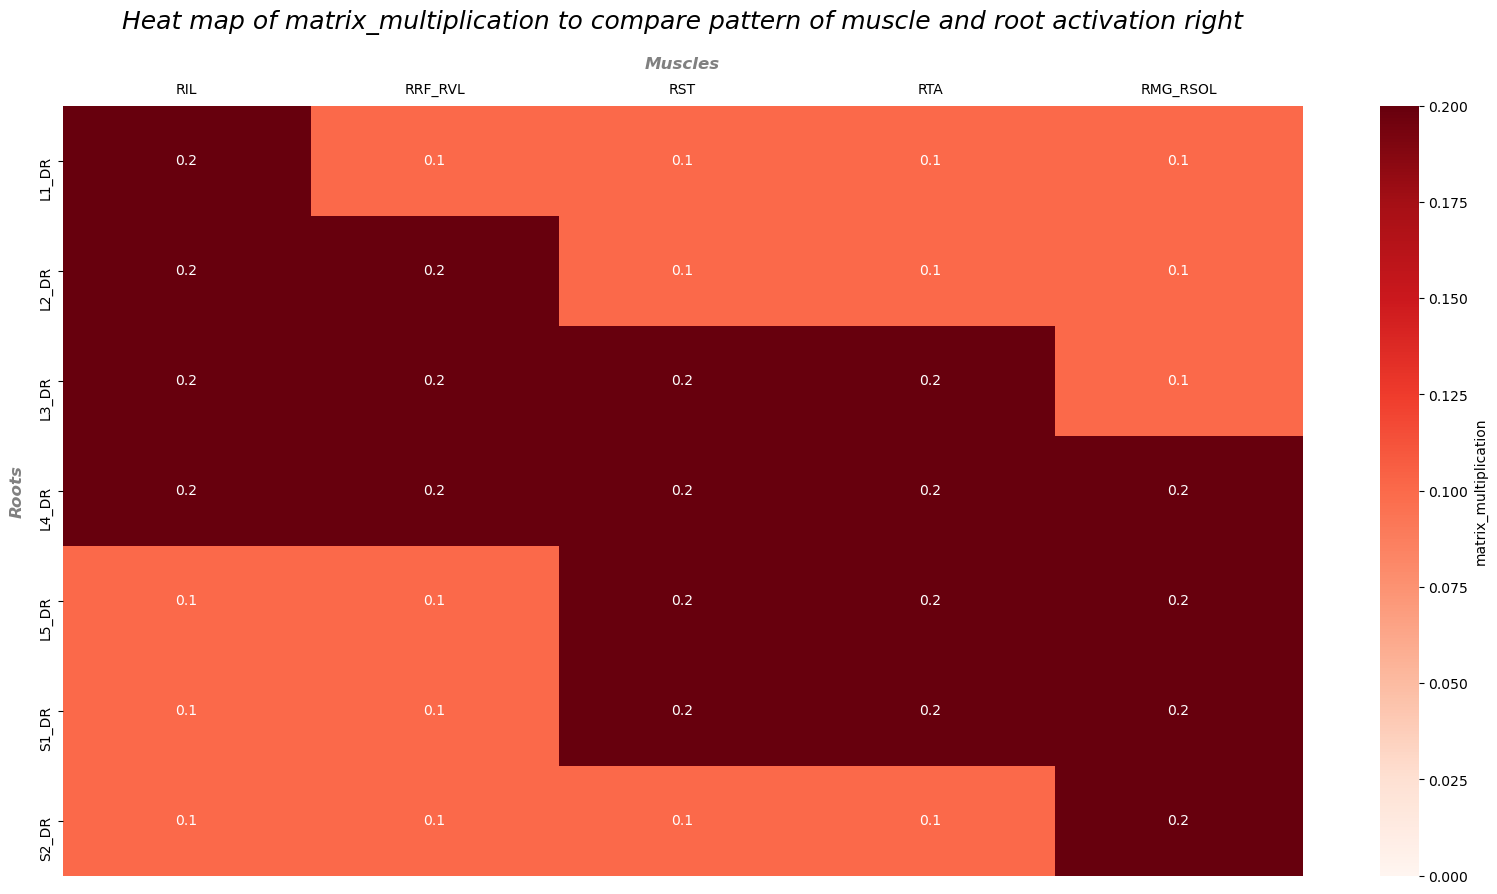

 visualising the projectome from the paper
 visualising the projectome from comparing heatmaps
Method: matrix multiplication was used to compare the activation pattern of muscles and roots


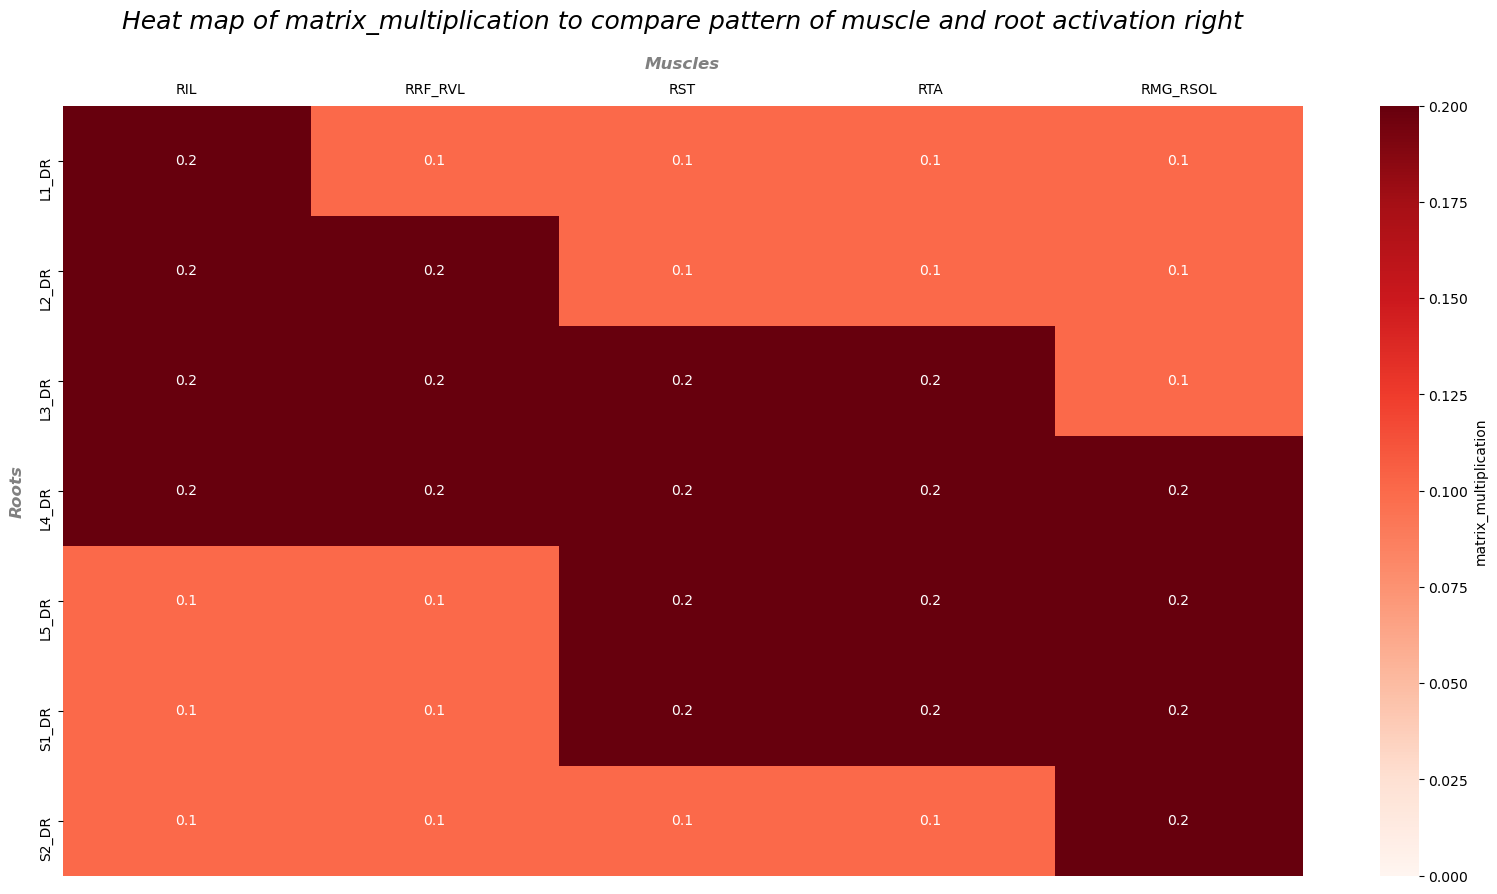

 visualising the projectome from sigmoid fitting


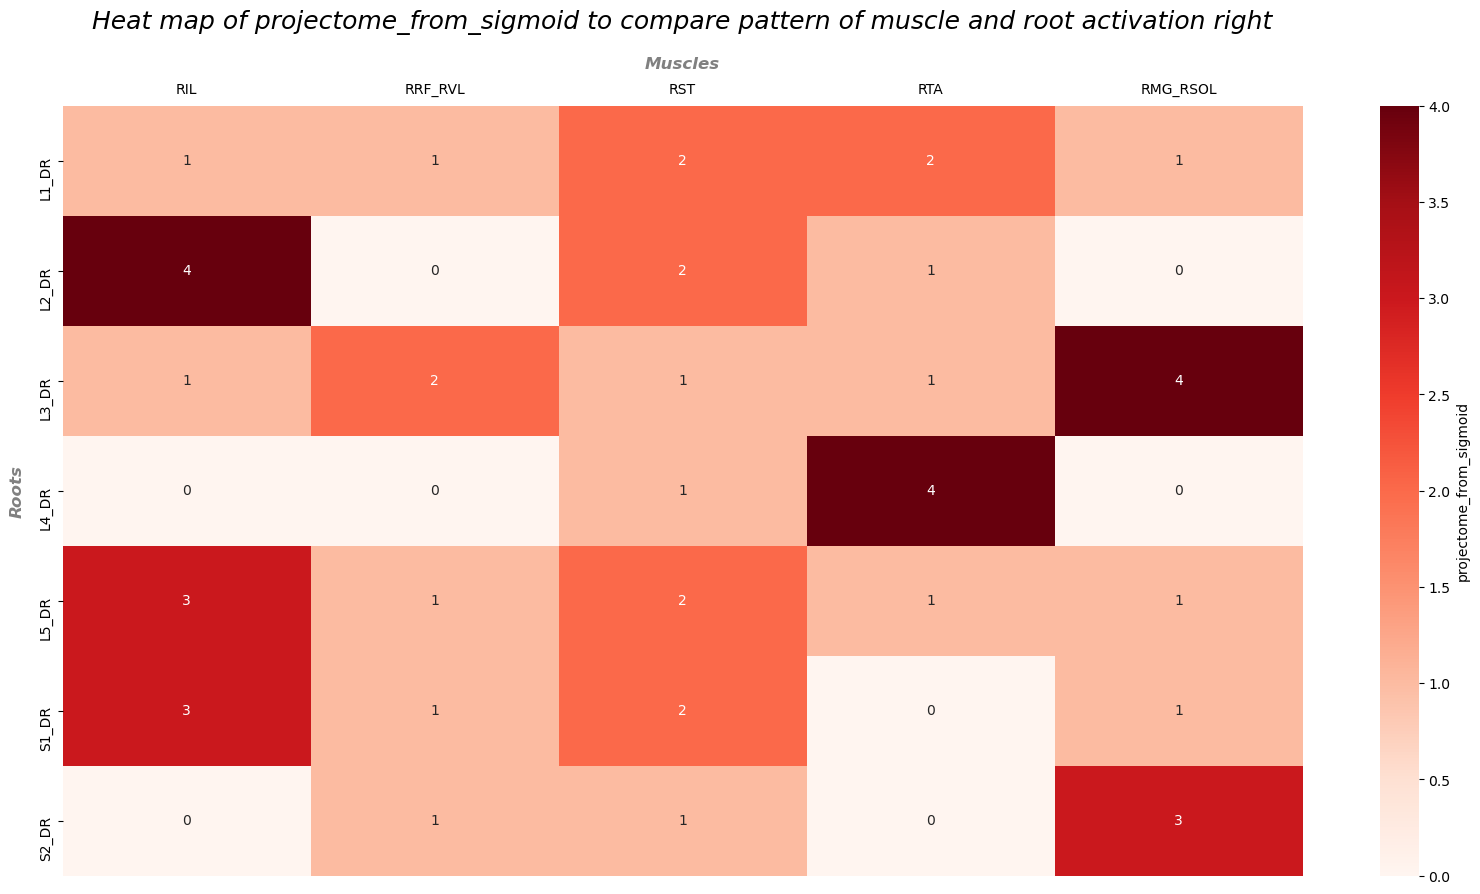

In [238]:
# result_multiplication=get_heatmap_results(projectome=0, method=1, save_fig=1 )
result_correlation=get_heatmap_results()
result_projectome=get_heatmap_results(projectome=1)
result_projectome=get_heatmap_results(sigmoid=1)



 visualising the projectome from comparing heatmaps
Method: matrix multiplication was used to compare the activation pattern of muscles and roots


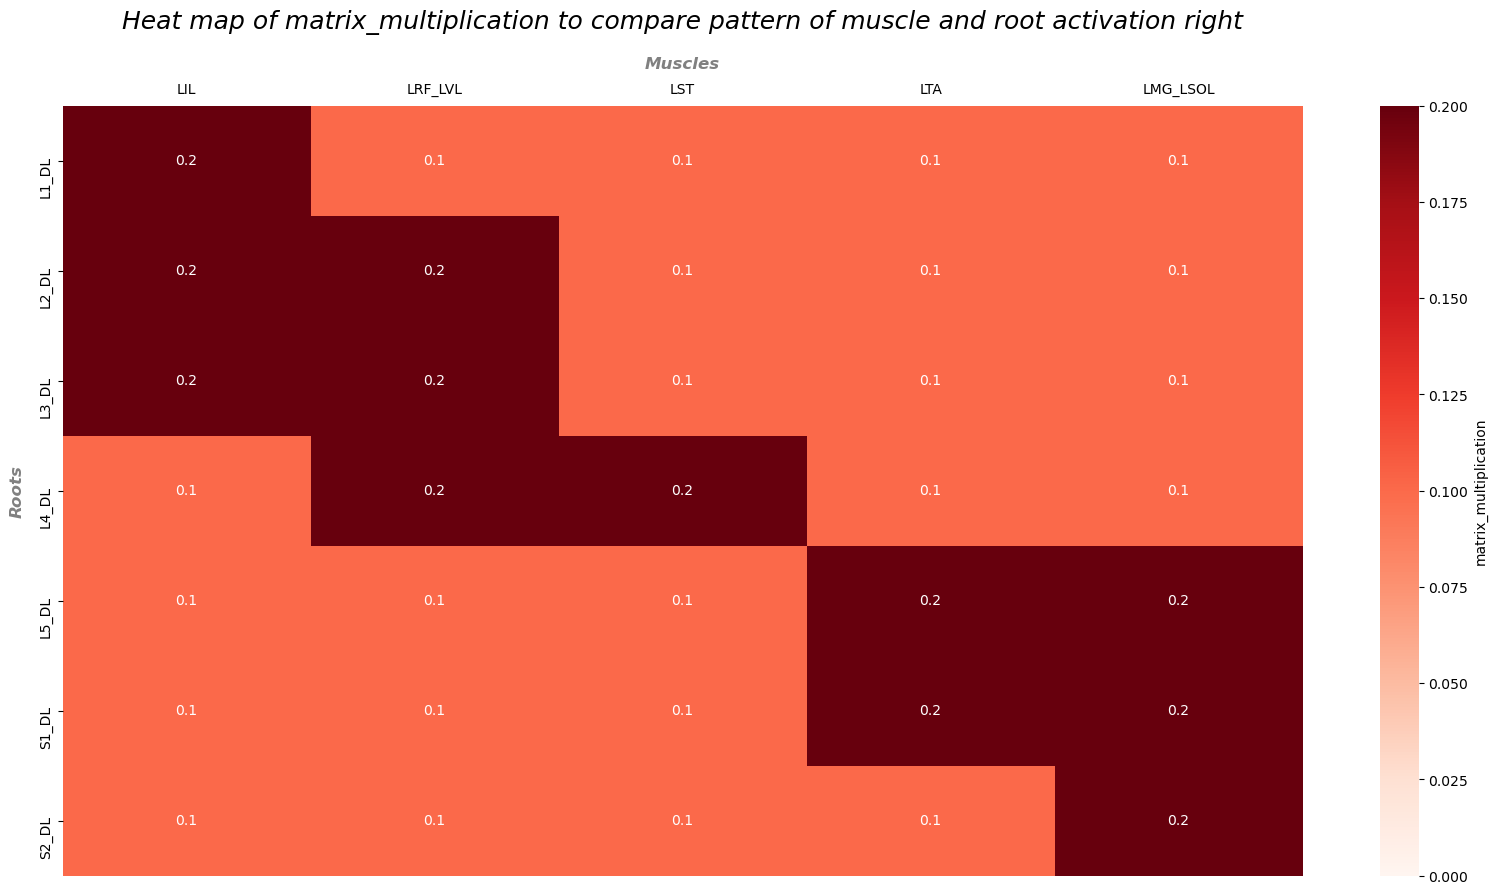

No projectome for the left side
 visualising the projectome from the paper
 visualising the projectome from comparing heatmaps
Method: matrix multiplication was used to compare the activation pattern of muscles and roots


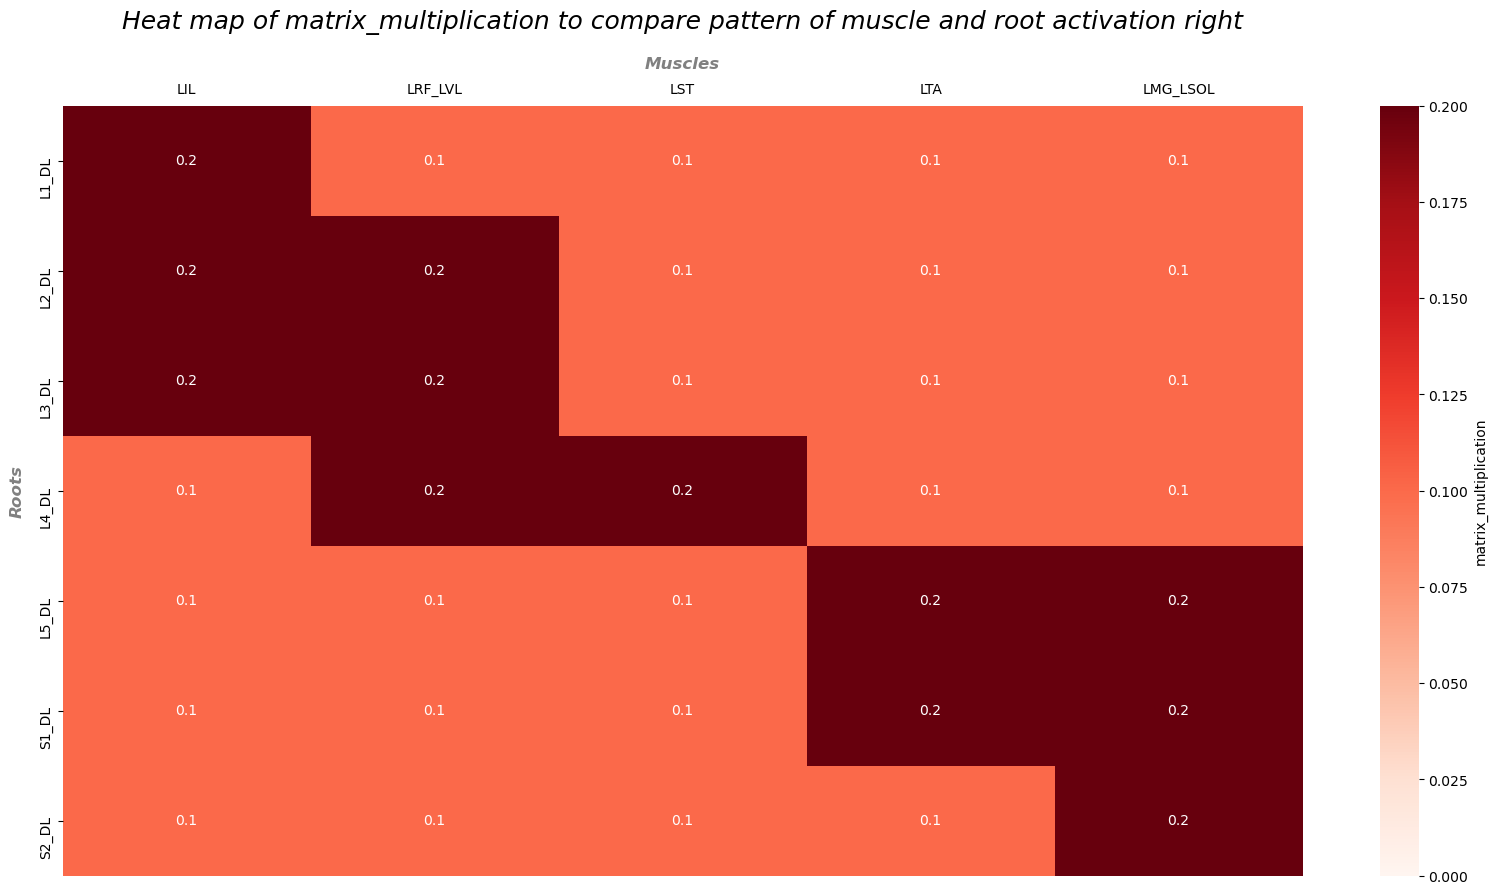

: 

In [244]:
result_correlation=get_heatmap_results(side=1)
result_projectome=get_heatmap_results(side=1,projectome=1)
# result_projectome=get_heatmap_results(sigmoid=1)

### Heat map SC arrangement

In [78]:

# per electrode which roots are activated
def get_heat_map_individual_root_recruitment(interpolation=0, save_fig=save_plot, interpol_method='cubic', text=neurons_text, muscles=muscles):
    """
    A function to create a heatmap  with and without interpolation.
    -Interpolation method can be adapted 'nearest', 'linear', 'cubic', by changing the interpolation function
    -data fed to the heatmap can be adapted by changing the 'get_number_for_heatmap' function


    Parameters
    ----------
    interpolation
        int, if set to one, generates heat maps with interpolation, 0 by default
    save_fig
        int, if set to 1 save figure, 0 by default
    interpol_method
        interpolation method, one of 'nearest', 'linear', 'cubic'
    text
        array used for annotation; to define electrodes in the plot
    muscles
        list of muscles
    """

   ## Define which normalisation method is used ##
    data=get_correlation_matrix()
    data_structure="correlation"
    # # ## turn one column into 100%
    # data=data/data.sum()
    # data=data.round(1)
    
    # data=get_number_for_heat_map_100_electric_current_normalise_by_max_root_response() # this wont work well bc interpolation doesnt work between 0 and 1
    # data_structure="100-electric_current_div_max_root_response"
   

    ## Define paddle lead
    if interpolation:
        print("Heat map s being interpolated")
        # Since it would round values between 0 and 1 to 0, we multiply data by 100
        data=data *100
        # Build tensor filled with -1, thus undefined values are easily recognisable ##    
        paddle_lead =np.zeros(80* 9)
        paddle_lead=np.array([-1]*len(paddle_lead))
        paddle_lead=paddle_lead.reshape((80,9))
        method="interpolated"

    else:
        print("No interpoaltion is used for the heat map")
        method="non_interpolated"
        paddle_lead =np.zeros(80* 9)
        paddle_lead=paddle_lead.reshape((80,9))

    ## Get the lead image as an array so we can plot it ##
    map_img=get_cropped_image(spinalcord=1)
    ## For every muscles fill spinal cord with values ##
    for muscle_i in muscles[3:9]: # LRF is rendering error, thus for now we only do some muscles
        # Set settings for plot ## 
        fig, ax = plt.subplots(figsize=(3,10))# creating subplot
        # Set title
        ax.set_title(f"{method} heat map for {muscle_i}", size=18, fontstyle='italic', pad=20)
    
        for position in [0]: # L1
    
            height_begin=4
            column_left=2
            column_right=6
            distance_between_roots=9
            # left
            root='L1_DL'
            for i in range(7):
                paddle_lead[height_begin+distance_between_roots*position+i][column_left] =data.loc[muscle_i][root]
            # right
            root='L1_DR'
            for i in range(7):
                paddle_lead[height_begin+distance_between_roots*position+i][column_right] =data.loc[muscle_i][root]

        for position in [1]: # L1, L2
            
            height_begin=4
            column_left=2
            column_right=6
            distance_between_roots=9
            # left
            root='L2_DL'
            for i in range(7):
                paddle_lead[height_begin+distance_between_roots*position+i][column_left] =data.loc[muscle_i][root]
            # right
            root='L2_DR'
            for i in range(7):
                paddle_lead[height_begin+distance_between_roots*position+i][column_right] =data.loc[muscle_i][root]

        for position in [2]: #  L3
            height_begin=4
            column_left=2
            column_right=6
            distance_between_roots=9
            # left
            root='L3_DL'
            for i in range(9):
                paddle_lead[height_begin+distance_between_roots*position+i][column_left] =data.loc[muscle_i][root]
            # right
            root='L3_DR'
            for i in range(9):
                paddle_lead[height_begin+distance_between_roots*position+i][column_right] =data.loc[muscle_i][root]
        
        for position in [0]: # L4,
            height_begin=34
            column_left=2
            column_right=6
            distance_between_roots=7
            root='L4_DL'
            for i in range(6):
                paddle_lead[height_begin+distance_between_roots*position+i][column_left] =data.loc[muscle_i][root]
            root='L4_DR'
            for i in range(6):
                paddle_lead[height_begin+distance_between_roots*position+i][column_right] =data.loc[muscle_i][root]

        for position in [1]: #  L5
            height_begin=35
            column_left=2
            column_right=6
            distance_between_roots=7
            root='L5_DL'
            for i in range(6):
                paddle_lead[height_begin+distance_between_roots*position+i][column_left] =data.loc[muscle_i][root]
            root='L5_DR'
            for i in range(6):
                paddle_lead[height_begin+distance_between_roots*position+i][column_right] =data.loc[muscle_i][root]

        for position in [0]: # S1

                    height_begin=49
                    column_left=2
                    column_right=6
                    distance_between_roots=7
                    root='S1_DL'
                    for i in range(5):
                        paddle_lead[height_begin+distance_between_roots*position+i][column_left] =data.loc[muscle_i][root]
                    root='S1_DR'
                    for i in range(5):
                        paddle_lead[height_begin+distance_between_roots*position+i][column_right] =data.loc[muscle_i][root]
        
        for position in [1]: #  S2

                    height_begin=48
                    column_left=2
                    column_right=6
                    distance_between_roots=7
                    root='S2_DL'
                    for i in range(5):
                        paddle_lead[height_begin+distance_between_roots*position+i][column_left] =data.loc[muscle_i][root]
                    root='S2_DR'
                    for i in range(5):
                        paddle_lead[height_begin+distance_between_roots*position+i][column_right] =data.loc[muscle_i][root]
                                
        ## put an X for max value
        # Find max value of paddle lead
        ind=np.where(paddle_lead == np.max(paddle_lead))
        # combine x and y value of indexes
        listOfCoordinates= list(zip(ind[0], ind[1]))
        # Create a new lead with size of paddle lead
        B=np.array(['']*(80* 9))
        B=B.reshape((80,9))
        # set  take position of one max value and set a star
        B[listOfCoordinates[3]]="X"
        # combining text with values
        formatted_text = (np.asarray(["{0}\n{1:}".format(
            text, B) for text, B in zip(text.flatten(), B.flatten())])).reshape((80,9))

        if interpolation:
            # interpolate unknown values
            # Create boolean, with true for the unknown values, which were set to -1, for interpolation #
            mask=paddle_lead<0
            ## Get interpolation for the unknown values ##
            interpolated_image=interpolate_missing_pixels(
            image=paddle_lead,
            mask=mask,
            method=interpol_method,
            fill_value= 0
            )
            ## Drawing heatmap on current axes ##
            hmax= sns.heatmap(
                data=interpolated_image, annot=formatted_text, fmt="",
                cmap=LinearSegmentedColormap.from_list('', ['white', 'r']),
                cbar_kws={'label': "Muscle activation [cV/A]"},
                yticklabels=False, xticklabels=False, vmin=0, 
                vmax=100, 
                alpha = 0.75, # whole heatmap is translucent
                zorder = 2,
                    )
          
        else:
            hmax= sns.heatmap(
            data=paddle_lead, annot=formatted_text, fmt="",
            cmap=LinearSegmentedColormap.from_list('', ['white', 'r']),
            cbar_kws={'label': "Muscle activation [V/A]"},
            yticklabels=False, xticklabels=False, vmin=0, 
            vmax=1, 
            alpha = 0.75, # whole heatmap is translucent
            zorder = 2,
                )

        ## put the image under the heatmap
        hmax.imshow(map_img,
            aspect = hmax.get_aspect(),
            extent =hmax.get_xlim() + hmax.get_ylim(),
            zorder = 1) 
        
        # ## Define Textbox
        # axbox = fig.add_axes([-0.5, 1.0, 1., 0.05]) #[left, bottom, width, height]
        # text_box = TextBox(axbox,label=None, textalignment="center")
        # text_box.set_val(data_structure)  # Trigger `submit` with the initial string.

        ## Save plots 
        if save_fig:
            folder_name= f"heatmap/evaluation/{method}/"
            data_file =muscle_i+"_"+"root"+"_"+"heat_map"+'.png'
            save_figure(folder_name, data_file)
        show() 
    
    return paddle_lead


Method: correlation was used to compare the activation pattern of muscles and roots
Heat map s being interpolated


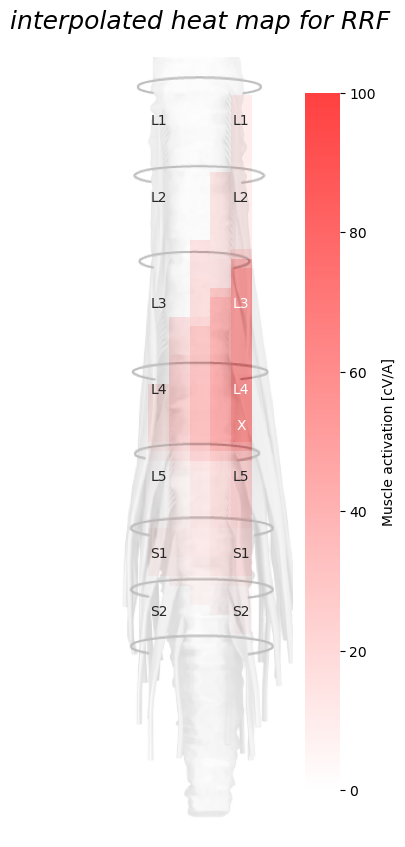

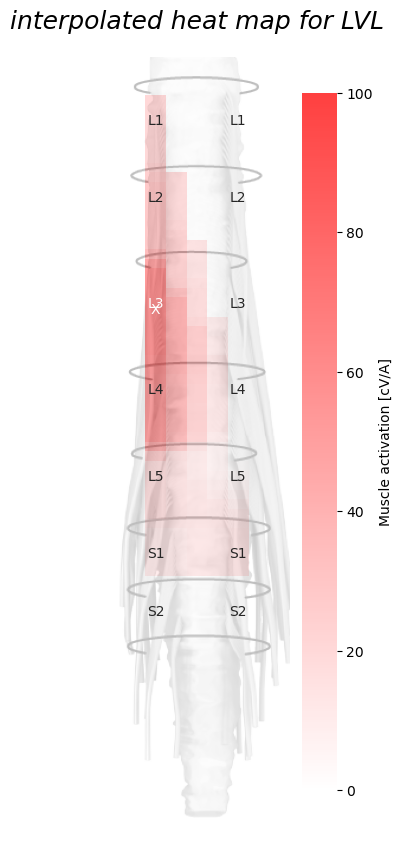

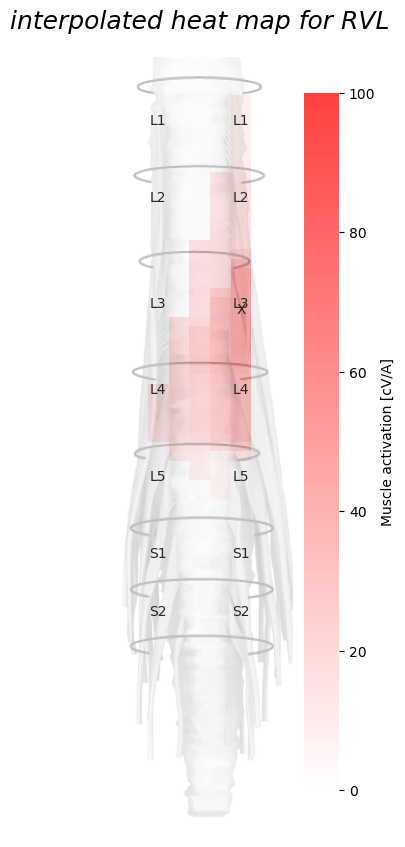

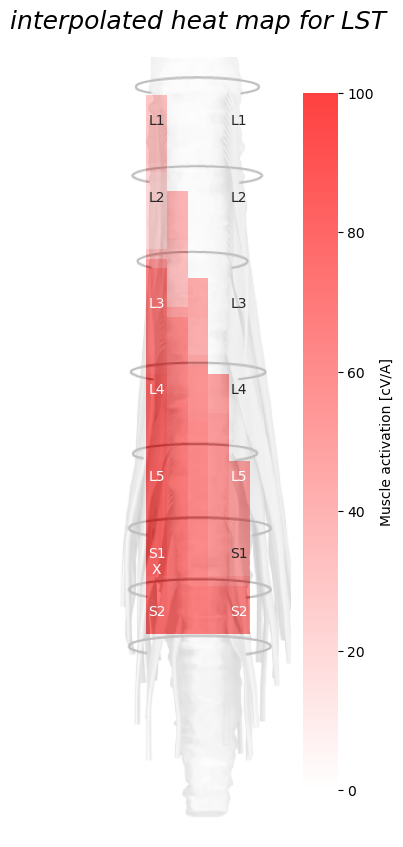

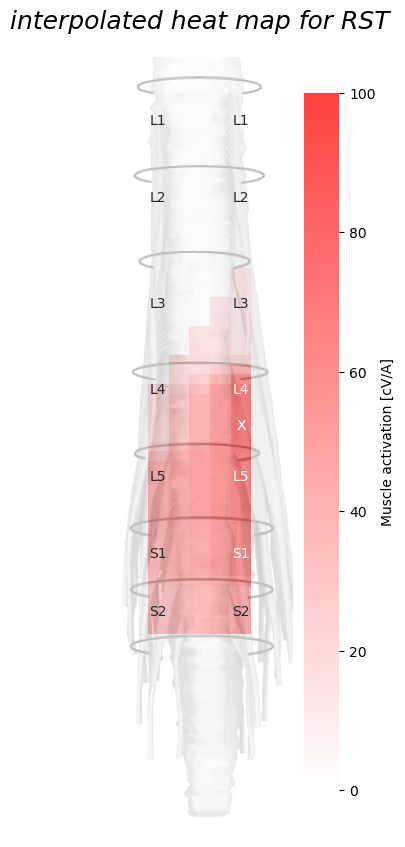

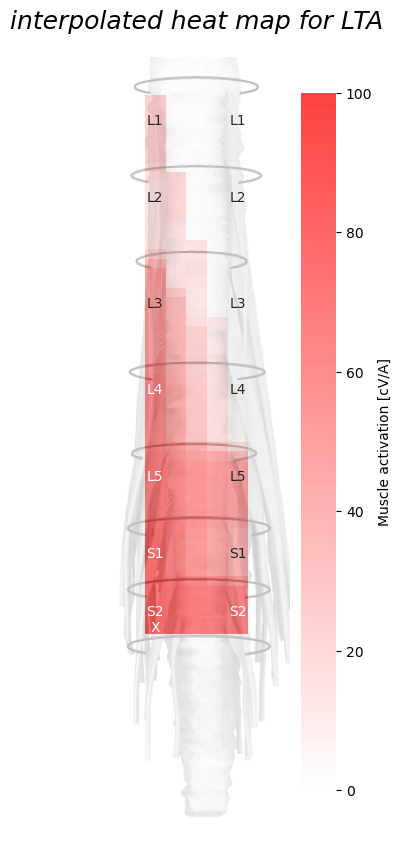

In [79]:
# if save_plot:
paddle_lead=get_heat_map_individual_root_recruitment(interpolation=1)

## Sigmoid

Here we want to compare the parameters.
The roots and muscles are differently scaled (muscles have given amplitudes while roots have arbitrary units) thus we cannot directly compare the parameters
Our approach\
parameter compared = X0, since it's the parameter accounting most for activation\
X0 is the position one in the tensor
1. For one electrode the sigmoid parameter of  a muscle, resp. a root is compared to the other muscles resp roots (assort)
2. Combine the the assortment of root and muscle\
since there is not the same amount of roots and muscles (muscles are innvervated by various roots) we take the first 3 results and combine them



In [80]:
# ### version all structures

# elec_i=0
# ## For muscles
# print(muscles_popt_sigmoid_right[elec_i,:, 1])
# X0_muscles_right=pd.DataFrame({"x0_values": np.array(muscles_popt_sigmoid_right[elec_i,:, 1]),"muscles_right": muscles_right})

# X0_muscles_right=X0_muscles_right.sort_values(by=['x0_values'])
# print(X0_muscles_right)

# ## for roots
# print(roots_popt_sigmoid_right[elec_i,:, 1])
# X0_roots_right=pd.DataFrame({"x0_values": np.array(roots_popt_sigmoid_right[elec_i,:, 1]),"rootss_right": roots_right})

# X0_roots_right=X0_roots_right.sort_values(by=['x0_values'])
# print(X0_roots_right)
# # pd.Dataframe("muscles_right": np.array(muscles_popt_sigmoid_right[elec_i,:, 1]) )
# # print(muscles_popt_sigmoid_right[elec_i,muscle_i, 1])

# # np.sort(np.array(muscles_popt_sigmoid_right[elec_i,:, 1]))


In [81]:
# Do the comparison for every elec and statistically  define which combination is most likely



In [82]:
def get_3_msc_or_rt_most_activated(X0_one_side,side,structure_class):

    if structure_class== "muscles":   
        # combine muscles
        RF=X0_one_side.filter(like='RF', axis=0).index.item() # get LRF resp RRF 
        VL=X0_one_side.filter(like='VL', axis=0).index.item() # get LVL RVL
        MG=X0_one_side.filter(like='MG', axis=0).index.item() # get RMG LMG
        SOL=X0_one_side.filter(like='SOL', axis=0).index.item() # get LSOL RSOL
        PS=X0_one_side.filter(like='PS', axis=0).index.item() # get LSOL RSOL

        X0_one_side.loc[f"{RF}_{VL}"] = [np.divide(np.add(X0_one_side.loc[RF].item(), X0_one_side.loc[VL].item()),2)]
        X0_one_side.loc[f"{MG}_{SOL}"] = [np.divide(np.add(X0_one_side.loc[MG].item(), X0_one_side.loc[SOL].item()),2)]
        X0_one_side=X0_one_side.drop(index=[MG, SOL,RF, VL, PS])



    if structure_class== "roots":   
        # drop roots same as in projectome
        if side:
            X0_one_side=X0_one_side.drop(index=["T12_DL",'S3_DL','S4_DL'])
        else:
            X0_one_side=X0_one_side.drop(index=["T12_DR",'S3_DR','S4_DR'])
        # # #sort 
        # X0_one_side=X0_one_side.sort_values(by=['x0_values'])
        # # # drop values and reset index
        # X0_one_side=X0_one_side.reset_index().drop(columns="x0_values")
    
    #sort 
    X0_one_side=X0_one_side.sort_values(by=['x0_values'])
    # drop X0 values and reset index
    X0_one_side=X0_one_side.drop(columns="x0_values").reset_index()


    return X0_one_side[0:3]

In [83]:
def compare_parameters_sigmoid(elec_i,side,structure_class,
muscles_popt_sigmoid_right=muscles_popt_sigmoid_right,roots_popt_sigmoid_right=roots_popt_sigmoid_right, muscles_popt_sigmoid_left=muscles_popt_sigmoid_left, roots_popt_sigmoid_left=roots_popt_sigmoid_left):


    
    roots_right=['T12_DR','L1_DR','L2_DR','L3_DR','L4_DR','L5_DR','S1_DR','S2_DR','S3_DR','S4_DR']



    if structure_class== "muscles":
        # popt_sigmoid_one_side=get_tensor_popt_per_combination(structure_class="muscles", side=side, plot=0)
        if side:
            popt_sigmoid_one_side=muscles_popt_sigmoid_left
            structure_name=['LIL','LRF', 'LVL','LST', 'LTA','LMG','LSOL', 'LPS'] # original
        else:
            popt_sigmoid_one_side=muscles_popt_sigmoid_right
            structure_name=['RIL','RRF', 'RVL','RST', 'RTA','RMG','RSOL', 'RPS'] # original
   
    if structure_class=="roots":
        # popt_sigmoid_one_side=get_tensor_popt_per_combination(structure_class="roots", side=side, plot=0)
        if side:
            popt_sigmoid_one_side=roots_popt_sigmoid_left
            structure_name=['T12_DL','L1_DL','L2_DL','L3_DL','L4_DL','L5_DL','S1_DL','S2_DL','S3_DL','S4_DL']
        else:
            popt_sigmoid_one_side=roots_popt_sigmoid_right
            structure_name=['T12_DR','L1_DR','L2_DR','L3_DR','L4_DR','L5_DR','S1_DR','S2_DR','S3_DR','S4_DR']


    X0_one_side=pd.DataFrame({"x0_values": np.array(popt_sigmoid_one_side[elec_i,:, 1]),structure_class: structure_name}).set_index(structure_class)
    X0_3_opt=get_3_msc_or_rt_most_activated(X0_one_side,side,structure_class)
    return X0_3_opt
        # opt_3_muscles=get_3_msc_or_rt_most_activated(X0_one_side,side,structure_class="muscles")
        # opt_3_roots=get_3_msc_or_rt_most_activated(X0_one_side,side,structure_class="roots")
        # pd.concat([opt_3_muscles, opt_3_roots],1).set_index(opt_3_muscles.columns[0])

In [84]:
def concat_muscles_and_roots_all_elecs(side, electrodes_from_listing=electrodes_from_listing):
    X0_combined_all_elecs=pd.DataFrame()
    for elec_i in range(len(electrodes_from_listing)):
    
        # get  parameters for the 3 primarily activated curves
        X0_muscles=compare_parameters_sigmoid(elec_i,side, structure_class="muscles")
        X0_roots=compare_parameters_sigmoid(elec_i,side, structure_class="roots")
        X0_combined=pd.concat([X0_muscles,X0_roots],axis=1)
        # print(f"X0_combined: {X0_combined}")

        X0_combined_all_elecs=pd.concat([X0_combined,X0_combined_all_elecs],axis=0)
        # print(f"X0_combined_all_elecs: {X0_combined_all_elecs}")
       
    return X0_combined_all_elecs
     

In [217]:
### get tensor per side with values per combination ####


muscles_right_projectome= ['RIL','RRF_RVL',  'RST', 'RTA','RMG_RSOL']
roots_right_projectome =['L1_DR','L2_DR','L3_DR','L4_DR','L5_DR','S1_DR','S2_DR']



if create_tensor:
    ### Create tensor to save the roots with same parameters for sigmoid
    # nMuslces x nroots x 1
    roots_per_muscle_tensor=torch.zeros(len(muscles_right_projectome),len(roots_right_projectome),1)
    print(roots_per_muscle_tensor.size())


#define function to merge columns with same names together
def same_merge(x): return ','.join(x[x.notnull()].astype(str))


muscles_right_projectome= ['RIL','RRF_RVL',  'RST', 'RTA','RMG_RSOL']
roots_right_projectome =['L1_DR','L2_DR','L3_DR','L4_DR','L5_DR','S1_DR','S2_DR']

b=concat_muscles_and_roots_all_elecs(0)
b=b.set_index("muscles")
b=b.transpose()
#define new DataFrame that merges columns with same names together
df_new = b.groupby(level=0, axis=1).apply(lambda x: x.apply(same_merge, axis=1))

#view new DataFrame
print(df_new)

## Goal to count the roots and plot in heatmap
len(df_new["RIL"].str.findall('S1_DR').item())
roots_per_muscle={}
for count_m, muscle_i in enumerate(muscles_right_projectome):
    for count_r, root_i in enumerate(roots_right_projectome):

        roots_per_muscle_tensor[count_m, count_r, 0]= torch.tensor(len(df_new[muscle_i].str.findall(root_i).item()))


## convert to df
roots_per_muscle_tensor.size()
roots_per_muscle_df=pd.DataFrame(torch.squeeze(roots_per_muscle_tensor, dim=2)).transpose()

torch.Size([5, 7, 1])
muscles                                                RIL  \
roots    L1_DR,L5_DR,L2_DR,L2_DR,L2_DR,S1_DR,L5_DR,L2_D...   

muscles                                           RMG_RSOL  \
roots    L3_DR,S1_DR,L3_DR,L3_DR,L3_DR,L5_DR,S2_DR,S2_D...   

muscles                              RRF_RVL  \
roots    L1_DR,L3_DR,S1_DR,L5_DR,S2_DR,L3_DR   

muscles                                                RST  \
roots    L4_DR,L5_DR,S2_DR,S1_DR,L1_DR,L2_DR,L3_DR,L5_D...   

muscles                                                RTA  
roots    L4_DR,L1_DR,L4_DR,L4_DR,L1_DR,L4_DR,L5_DR,L3_D...  


In [88]:
X0_combined_all_elecs=pd.DataFrame()
# get  parameters for the 3 primarily activated curves
elec_i=0
side=0
X0_muscles=compare_parameters_sigmoid(elec_i,side, structure_class="muscles")
X0_roots=compare_parameters_sigmoid(elec_i,side, structure_class="roots")
X0_combined=pd.concat([X0_muscles,X0_roots],axis=1)
print(f"X0_combined: {X0_combined}")

X0_combined_all_elecs=pd.concat([X0_combined,X0_combined_all_elecs],axis=0)
print(f"X0_combined_all_elecs with nothing: {X0_combined_all_elecs}")




elec_i=1
# get  parameters for the 3 primarily activated curves
X0_muscles=compare_parameters_sigmoid(elec_i,side, structure_class="muscles")
X0_roots=compare_parameters_sigmoid(elec_i,side, structure_class="roots")
X0_combined=pd.concat([X0_muscles,X0_roots],axis=1)
print(f"X0_combined: {X0_combined}")

X0_combined_all_elecs=pd.concat([X0_combined,X0_combined_all_elecs],axis=0)
print(f"X0_combined_all_elecs with nothing: {X0_combined_all_elecs}")  


X0_combined:   muscles  roots
0     RTA  L2_DR
1     RST  L1_DR
2     RIL  L3_DR
X0_combined_all_elecs with nothing:   muscles  roots
0     RTA  L2_DR
1     RST  L1_DR
2     RIL  L3_DR
X0_combined:     muscles  roots
0  RMG_RSOL  L1_DR
1       RST  L2_DR
2       RTA  L3_DR
X0_combined_all_elecs with nothing:     muscles  roots
0  RMG_RSOL  L1_DR
1       RST  L2_DR
2       RTA  L3_DR
0       RTA  L2_DR
1       RST  L1_DR
2       RIL  L3_DR


In [ ]:
X0_combined_all_elecs=pd.DataFrame()
   
elec_i=0  
side=0
# get  parameters for the 3 primarily activated curves
X0_muscles=compare_parameters_sigmoid(elec_i,side, structure_class="muscles")
X0_roots=compare_parameters_sigmoid(elec_i,side, structure_class="roots")
X0_combined=pd.concat([X0_muscles,X0_roots],axis=1)
print(X0_combined)

X0_combined_all_elecs=pd.concat([X0_combined_all_elecs,X0_combined],axis=0)
print(X0_combined_all_elecs)

  muscles  roots
0     RTA  L2_DR
1     RST  L1_DR
2     RIL  L3_DR
  muscles  roots
0     RTA  L2_DR
1     RST  L1_DR
2     RIL  L3_DR


In [ ]:
XO_combined_all_elecs=concat_muscles_and_roots_all_elecs(0)
print(XO_combined_all_elecs)

         roots
muscles       
RTA      L2_DR
RST      L1_DR
RIL      L3_DR
Empty DataFrame
Columns: []
Index: []
         roots
muscles       
RTA      L2_DR
RST      L1_DR
RIL      L3_DR
         roots
muscles       
RTA      L2_DR
RST      L1_DR
RIL      L3_DR


In [ ]:
X0_roots_right=pd.DataFrame({"x0_values": np.array(roots_popt_sigmoid_right[elec_i,:, 1]),"roots_right": roots_right})
# set roots as index
X0_roots_right=X0_roots_right.set_index('roots_right')
X0_one_side=X0_roots_right
opt_rt=get_3_msc_or_rt_most_activated(X0_one_side, side=0,structure_class="roots")
print(opt_rt)

  roots_right
0       L2_DR
1       L1_DR
2       L3_DR


# Combine all the functions and make it faster!!

1. get simoid fit (tensor creatio for l, r X m,r)
2. make it same layout as projectome (function on its own, so you can choose to do it or not)
3. get the 3 paramters for best activatoin
4. combine mscl and root for all elecs 
5. scatterplot where you see which muscle and which root connect most